### Todos

- 17. Beschreiben des Mehrwerts des “finalen” Modelles in der Praxis.

- Markdown writing and explain what we have done
- Clean up code: (Imports in central place, Comments, Code Refactor)


### Datenübersicht / ERM:

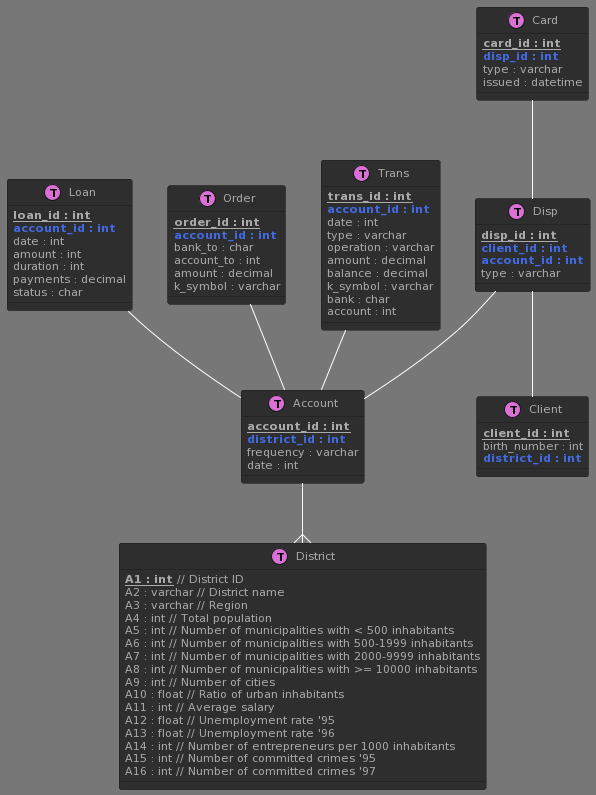

# Setup
Die folgenden Code-Blöcke können genutzt werden, um die benötigten Abhängigkeiten zu installieren und zu importieren.

In [1]:
%%capture
%pip install -r ../requirements.txt


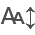

In [2]:
from itables import show
from itables import init_notebook_mode

init_notebook_mode()

In [3]:
# Laden der eingesetzten Libraries
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
from IPython.display import display
from itables import init_notebook_mode
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
)
from sklearn.metrics import (
    roc_curve,
    auc,
    make_scorer,
    confusion_matrix,
    ConfusionMatrixDisplay,
    fbeta_score,
    cohen_kappa_score,
    matthews_corrcoef,
)
import lime.lime_tabular
import shap

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from tqdm import tqdm
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

In [4]:
%%capture
# set theme ggplot for plots
plt.style.use("ggplot")
# set display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [5]:
# Funktion zur Bestimmung des Geschlechts und Berechnung des Geburtstags
def parse_details(birth_number):
    birth_number_str = str(
        birth_number
    )  # Konvertiere birth_number zu einem String, falls notwendig
    year_prefix = "19"
    month = int(birth_number_str[2:4])
    gender = "female" if month > 12 else "male"
    if gender == "female":
        month -= 50
    year = int(year_prefix + birth_number_str[:2])
    day = int(birth_number_str[4:6])
    birth_day = datetime(year, month, day)
    return gender, birth_day


# Berechnung des Alters basierend auf einem Basisjahr
def calculate_age(birth_date, base_date=datetime(1999, 12, 31)):
    return (
        base_date.year
        - birth_date.year
        - ((base_date.month, base_date.day) < (birth_date.month, birth_date.day))
    )


# Regression metrics
def regression_results(y_true, y_pred):
    print(
        "explained_variance: ",
        round(metrics.explained_variance_score(y_true, y_pred), 4),
    )
    print(
        "mean_squared_log_error: ",
        round(metrics.mean_squared_log_error(y_true, y_pred), 4),
    )
    print("r2: ", round(metrics.r2_score(y_true, y_pred), 4))
    print("MAE: ", round(metrics.mean_absolute_error(y_true, y_pred), 4))
    print("MSE: ", round(metrics.mean_squared_error(y_true, y_pred), 4))
    print("RMSE: ", round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 4))

# Aufgabenstellung
Inhalt der hier bearbeiteten und dokumentierten Mini-Challenge für das Modul «aml - Angewandtes Machine Learning» der FHNW ist die Entwicklung und Evaluierung von Aﬀinitätsmodellen für personalisierte Kreditkarten-Werbekampagnen im Auftrag einer Bank. Das Ziel der Authoren ist es also, mithilfe von Kunden- und Transaktionsdaten präzise Modelle zu erstellen, die die Wahrscheinlichkeit des Kreditkartenkaufs einer bestimmten Person vorhersagen.

# Laden der zur Verfügung gestellten Daten
[//]: # (-.- .tabset)

Zur Verfügung gestellt wurden 8 csv-Dateien von welchen die Beschreibung der erfassten Variablen unter dem folgenden Link eingesehen werden können: [PKDD'99 Discovery Challenge - Guide to the Financial Data Set](https://sorry.vse.cz/~berka/challenge/PAST/index.html). Nachfolgend werden diese csv-Dateien eingelesen.

In [6]:
account = pd.read_csv("./data/account.csv", sep=";", dtype={"date": "str"})
card = pd.read_csv("./data/card.csv", sep=";", dtype={"issued": "str"})
client = pd.read_csv("./data/client.csv", sep=";")
disp = pd.read_csv("./data/disp.csv", sep=";")
district = pd.read_csv("./data/district.csv", sep=";")
loan = pd.read_csv("./data/loan.csv", sep=";", dtype={"date": "str"})
order = pd.read_csv("./data/order.csv", sep=";")
trans = pd.read_csv("./data/trans.csv", sep=";", dtype={"date": "str", "bank": "str"})

# Datenaufbereitung & Explorative Datenanalyse
Im folgenden Abschnitt werden die geladenen Daten separat so transformiert, dass jede Zeile einer Observation und jede Spalte einer Variable im entsprechenden Datenformat entspricht, also ins Tidy-Format gebracht.

In [7]:
data_frames = {}

## Account
[//]: # (-.- .tabset)
Der Datensatz `accounts.csv` beinhaltet 4500 Observationen mit den folgenden Informationen über die Kontos der Bank: 
   
- `account_id`: die Kontonummer,  
- `district_id`: den Standort der entsprechenden Bankfiliale,  
- `frequency`: die Frequenz der Ausstellung von Kontoauszügen (monatlich, wöchentlich, pro Transaktion) und  
- `date`: das Erstellungsdatum

In [8]:
account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   account_id   4500 non-null   int64 
 1   district_id  4500 non-null   int64 
 2   frequency    4500 non-null   object
 3   date         4500 non-null   object
dtypes: int64(2), object(2)
memory usage: 140.8+ KB


In [9]:
print("Anzahl fehlender Werte:", sum(account.isnull().sum()))
print("Anzahl duplizierter Einträge:", account.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Aufbereitung
Nachfolgend wird die `date` Spalte des `account.csv`-Datensatzes in das entsprechende Datenformat geparsed und die Werte von `frequency` übersetzt und als Levels einer Kategorie definiert.

In [10]:
# parse date
account["date"] = pd.to_datetime(account["date"], format="%y%m%d")
# translate categories
account["frequency"] = account["frequency"].replace(
    {
        "POPLATEK MESICNE": "monthly",
        "POPLATEK TYDNE": "weekly",
        "POPLATEK PO OBRATU": "transactional",
    }
)

# convert column frequency to categorical
account["frequency"] = account["frequency"].astype("category")

# sample 5 random rows
account.sample(n=5)

,account_id,district_id,frequency,date
179,2242,7,weekly,1993-02-25
3720,2766,31,monthly,1997-02-20
2858,140,24,monthly,1996-06-25
382,3965,31,monthly,1993-05-04
1935,3357,54,monthly,1995-07-26


### Distrikt
Hier zu sehen ist die Verteilung der Distrikte pro Bankkonto. Ersichtlich ist, dass im Distrikt 1 mit Abstand am meisten Bankkontos geführt werden. Die darauf folgenden Distrikte bewegen sich alle im Bereich zwischen ~250 - 50 Bankkonten.  

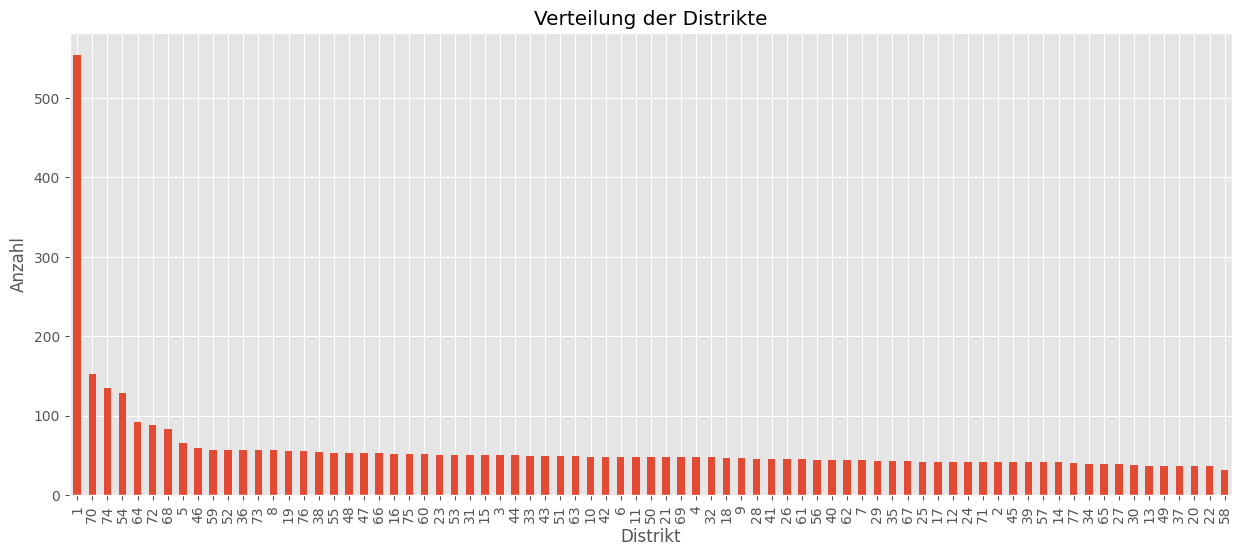

In [11]:
# plot the distribution of the district_ids and replace the id with it's name
plt.figure(figsize=(15, 6))
account["district_id"].value_counts().plot(kind="bar")
plt.title("Verteilung der Distrikte")
plt.xlabel("Distrikt")
plt.ylabel("Anzahl")
plt.show()

### Frequenz
Auf dieser Visualisierung zu sehen ist die Klassenverteilung der Frequenz der Ausstellung der Kontoauszüge. Die allermeisten Bankkonten besitzen eine monatliche Ausstellung.

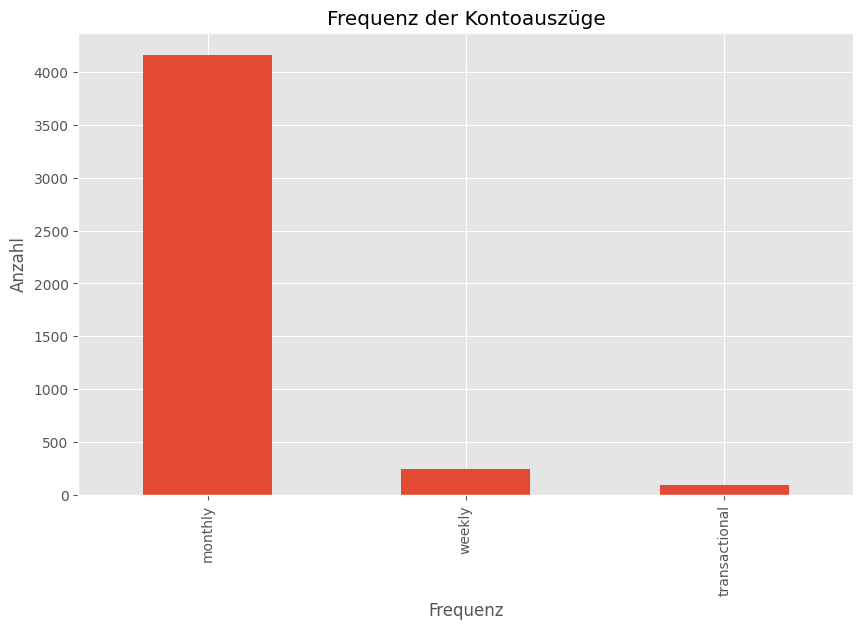

In [12]:
# Verteilung der Frequenz visualisieren
plt.figure(figsize=(10, 6))
account["frequency"].value_counts().plot(kind="bar")
plt.title("Frequenz der Kontoauszüge")
plt.xlabel("Frequenz")
plt.ylabel("Anzahl")
plt.show()

### Datum
Der hier dargestellte Plot zeigt die Verteilung der Kontoerstellungsdaten. Das erste Konto wurde im Jahr 1993 und das neuste im 1998 erstellt.  

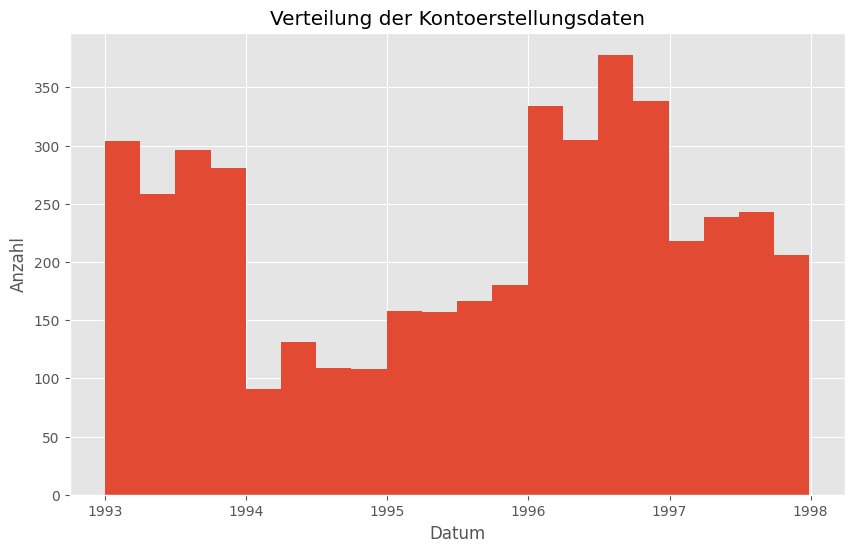

In [13]:
# plot date distribution
plt.figure(figsize=(10, 6))
plt.hist(account["date"], bins=20)
plt.title("Verteilung der Kontoerstellungsdaten")
plt.xlabel("Datum")
plt.ylabel("Anzahl")
plt.show()

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/accounts.html) entnommen werden. 

In [14]:
# append account data to dataframe collection
data_frames["account.csv"] = account

In [15]:
# %%capture
# # generate sweetviz report
# svReport_account = sv.analyze(account)
# svReport_account.show_html(filepath="./reports/accounts.html", open_browser=False)

## Card
[//]: # (-.- .tabset)

Der Datensatz `card.csv` beinhaltet 892 Observationen mit den folgenden Informationen über die von der Bank herausgegebenen Kreditkarten:  

- `card_id`: die Kartennummer,  
- `disp_id`: die Zuordnung zum entsprechenden Bankkonto und -inhaber (Disposition),  
- `type`: die Art der Kreditkarte (junior, classic, gold) und  
- `issued`: das Ausstellungsdatum

In [16]:
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   card_id  892 non-null    int64 
 1   disp_id  892 non-null    int64 
 2   type     892 non-null    object
 3   issued   892 non-null    object
dtypes: int64(2), object(2)
memory usage: 28.0+ KB


In [17]:
print("Anzahl fehlender Werte:", sum(card.isnull().sum()))
print("Anzahl duplizierter Einträge:", card.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Aufbereitung
Auch bei diesem Datensatz (`card.csv`) werden zunächst die Datentypen korrigiert um anschliessend die Inhalte entsprechend beschreiben zu können

In [18]:
# parse date
card["issued"] = pd.to_datetime(card["issued"].str[:6], format="%y%m%d")
card["issued"] = card["issued"].dt.to_period("M")
# convert type to categorical
card["type"] = card["type"].astype("category")

card.sample(n=5)

,card_id,disp_id,type,issued
611,831,6275,classic,1998-06
461,474,3066,junior,1998-01
695,1150,12020,classic,1998-08
135,303,1912,classic,1996-08
281,353,2259,classic,1997-06


### Kartentyp
Hier dargestellt ist die Klassenverteilung der Kartentypen. Die meisten Karteninhaber besitzen eine klassische Kreditkarte, gefolgt von ~180 junior- und ~100 gold Karten.  

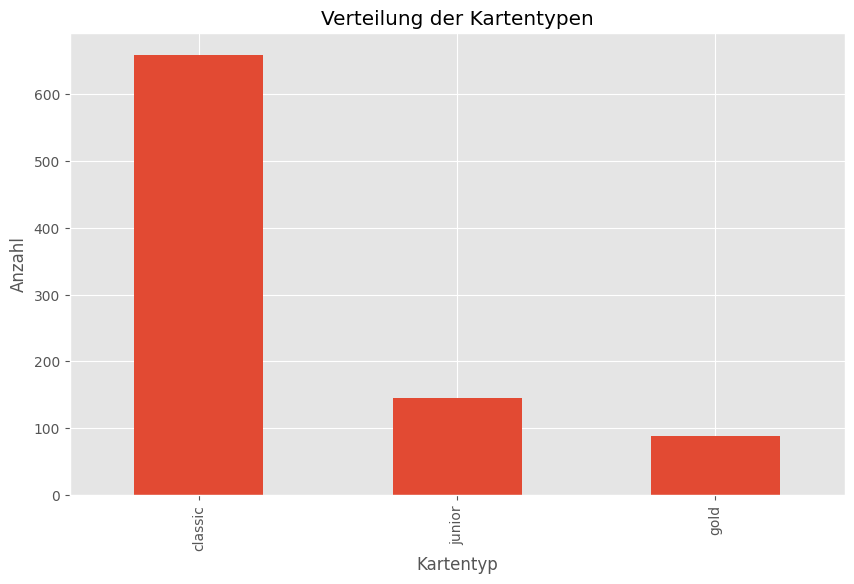

In [19]:
# plot distribution of type
plt.figure(figsize=(10, 6))
card["type"].value_counts().plot(kind="bar")
plt.title("Verteilung der Kartentypen")
plt.xlabel("Kartentyp")
plt.ylabel("Anzahl")
plt.show()

### Ausstellungsdatum
Hier dargestellt ist die Häufigkeit von Kreditkartenausstellungen pro Monat. Erkennbar ist eine steigende Tendenz mit einem Rückgang in den Monaten Februar - April 1997.  

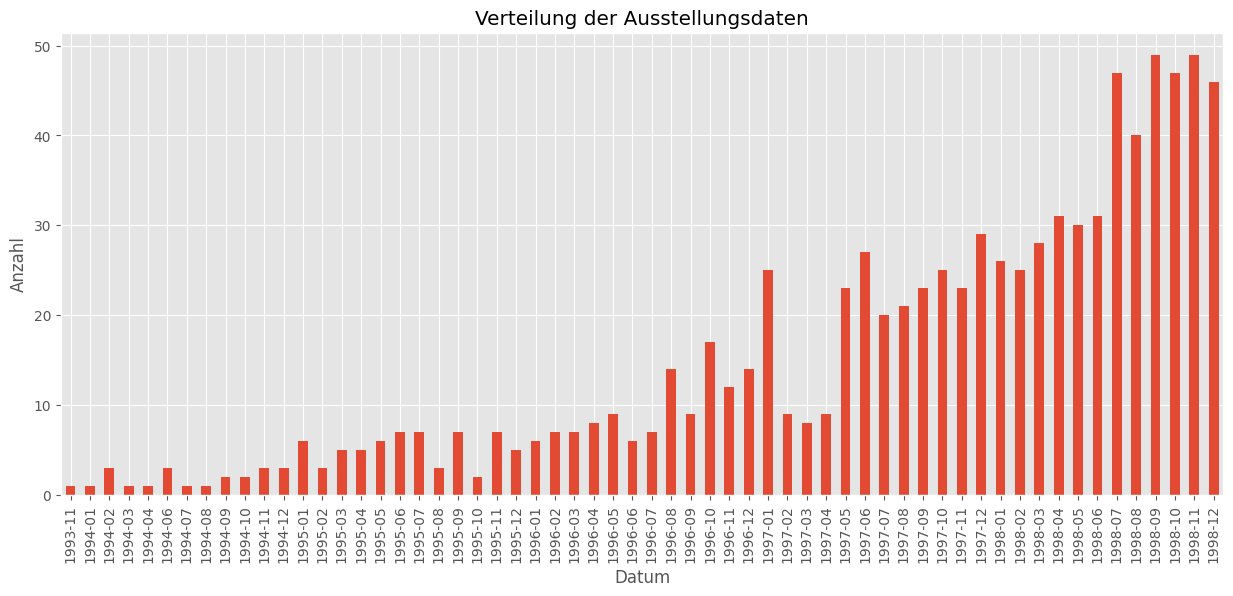

In [20]:
# plot issued date per month and year
plt.figure(figsize=(15, 6))
card["issued"].value_counts().sort_index().plot(kind="bar")
plt.title("Verteilung der Ausstellungsdaten")
plt.xlabel("Datum")
plt.ylabel("Anzahl")
plt.show()

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/card.html) entnommen werden.

In [21]:
# append to dataframes collection
data_frames["card.csv"] = card

In [22]:
# %%capture
# # generate sweetviz report
# svReport_card = sv.analyze(card)
# svReport_card.show_html(filepath="./reports/card.html", open_browser=False)

## Client
[//]: # (-.- .tabset)

Der Datensatz `client.csv` beinhaltet 5369 Observationen mit den folgenden Informationen über die Kunden der Bank:  

- `client_id`: die Kundennummer,  
- `birth_number`: eine Kombination aus Geburtsdatum und Geschlecht sowie  
- `district_id`: die Adresse   

In [23]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   client_id     5369 non-null   int64
 1   birth_number  5369 non-null   int64
 2   district_id   5369 non-null   int64
dtypes: int64(3)
memory usage: 126.0 KB


In [24]:
print("Anzahl fehlender Werte:", sum(client.isnull().sum()))
print("Anzahl duplizierter Einträge:", client.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Aufbereitung
Die Spalte `birth_number` des `client.csv`-Datensatzes codiert 3 Features der Bankkunden: Geschlecht, Geburtsdatum und damit auch das Alter. Diese Informationen werden mithilfe der zuvor definierten Funktionen `parse_details()` und `calculate_age` extrahiert.

In [25]:
# Geburtstag & Geschlecht aus birth_number extrahieren
client["gender"], client["birth_day"] = zip(
    *client["birth_number"].apply(parse_details)
)
client["gender"] = client["gender"].astype("category")
# Alter berechnen
client["age"] = client["birth_day"].apply(calculate_age)

# Spalte birth_number entfernen
client = client.drop(columns=["birth_number"])

# Sample 5 random rows
client.sample(n=5)

,client_id,district_id,gender,birth_day,age
2928,3093,35,male,1966-02-21,33
738,774,70,male,1973-03-03,26
4457,4716,10,female,1933-08-02,66
2348,2477,75,male,1952-06-14,47
5211,11857,70,male,1952-08-26,47


### Geschlecht
Hier dargestellt ist die Verteilung des Geschlechts der Bankkunden. Das Geschlecht der erfassten Bankkunden ist fast gleichverteilt mit einem etwas kleineren Frauenanteil.  

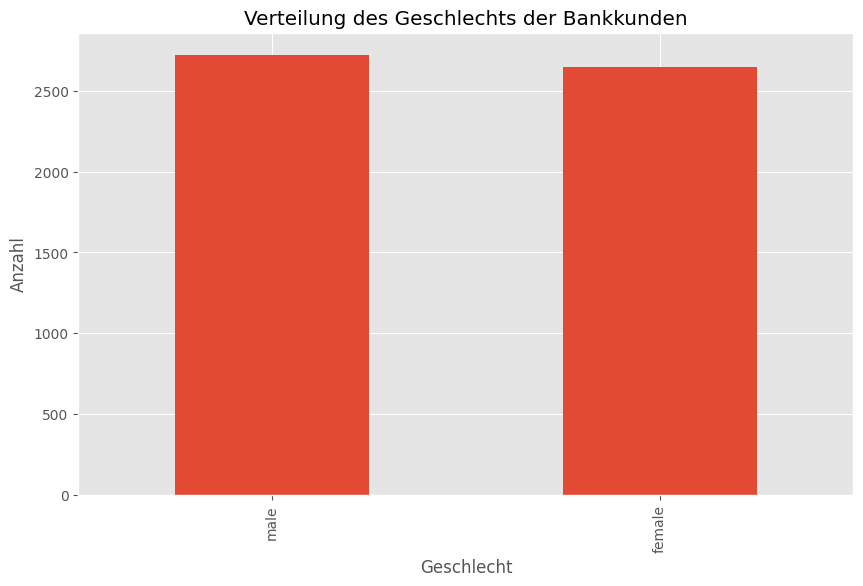

In [26]:
# plot distribution of gender
plt.figure(figsize=(10, 6))
gender_distribution = client["gender"].value_counts().plot(kind="bar")
plt.title("Verteilung des Geschlechts der Bankkunden")
plt.xlabel("Geschlecht")
plt.ylabel("Anzahl")
plt.show()

### Alter
Nachfolgend abgebildet ist die Verteilung des Alters der Bankkunden. Die jüngste erfasste Person ist 12 Jahre alt und die älteste 88. 

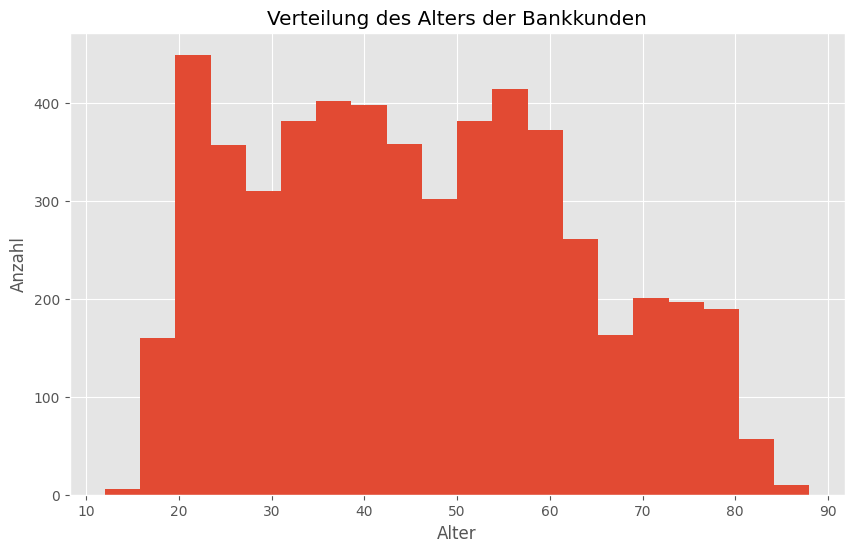

In [27]:
# plot distribution of age
plt.figure(figsize=(10, 6))
client["age"].plot(kind="hist", bins=20)
plt.title("Verteilung des Alters der Bankkunden")
plt.xlabel("Alter")
plt.ylabel("Anzahl")
plt.show()

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/client.html) entnommen werden.

In [28]:
data_frames["client.csv"] = client

In [29]:
# %%capture
# svReport_client = sv.analyze(client)
# svReport_client.show_html(filepath="./reports/client.html", open_browser=False)

## Disp
[//]: # (-.- .tabset)

Der Datensatz `disp.csv` beinhaltet 5369 Observationen mit den folgenden Informationen über die Dispositionen der Bank:   

- `disp_id`: der Identifikationsschlüssel der Disposition,  
- `client_id`: die Kundennummer,  
- `account_id`: die Kontonummer,  
- `type`: die Art der Disposition (Inhaber, Benutzer)

In [30]:
disp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   disp_id     5369 non-null   int64 
 1   client_id   5369 non-null   int64 
 2   account_id  5369 non-null   int64 
 3   type        5369 non-null   object
dtypes: int64(3), object(1)
memory usage: 167.9+ KB


In [31]:
print("Anzahl fehlender Werte:", sum(disp.isnull().sum()))
print("Anzahl duplizierter Einträge:", disp.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Aufbereitung
Auch die Variablen des Datensatzes `disp.csv` werden in die korrekten Datentypen übertragen. 

In [32]:
# Spalte type als Kategorie speichern
disp["type"] = disp["type"].astype("category")

# random sample
disp.sample(n=5)

,disp_id,client_id,account_id,type
961,1015,1015,842,OWNER
1888,2001,2001,1651,OWNER
4414,4670,4670,3874,OWNER
2370,2499,2499,2060,OWNER
4909,7594,7594,6289,OWNER


### Typ der Disposition
Hier dargestellt ist die Verteilung der Art der Dispositionen. 4500 Kunden sind Inhaber eines Kontos und 896 sind Disponenten. 

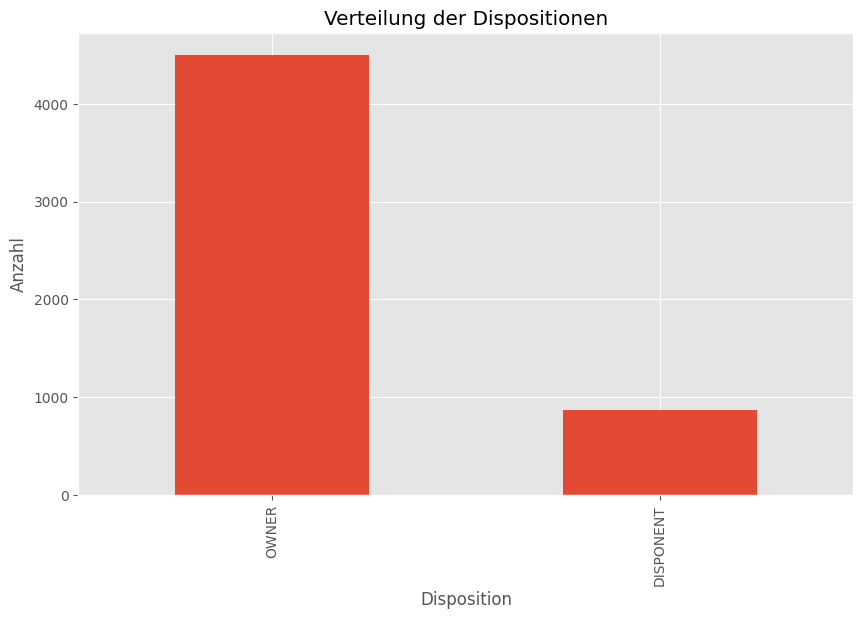

In [33]:
# plot distribution of kind
plt.figure(figsize=(10, 6))
disp["type"].value_counts().plot(kind="bar")
plt.title("Verteilung der Dispositionen")
plt.xlabel("Disposition")
plt.ylabel("Anzahl")
plt.show()

In [34]:
# remove disponents
disp = disp[disp["type"] == "OWNER"]

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/disp.html) entnommen werden.

In [35]:
data_frames["disp.csv"] = disp

In [36]:
# %%capture
# svReport_disp = sv.analyze(disp)
# svReport_disp.show_html(filepath="./reports/disp.html", open_browser=False)

## District
[//]: # (-.- .tabset)

Der Datensatz `district.csv` beinhaltet 77 Observationen mit den folgenden demografischen Informationen:   

- `A1`: die ID des Distrikts,  
- `A2`: der Name des Distrikts,  
- `A3`: die Region,  
- `A4`: die Anzahl der Einwohner,  
- `A5`: die Anzahl der Gemeinden mit < 499 Einwohner,  
- `A6`: die Anzahl der Gemeinden mit 500 - 1999 Einwohner,  
- `A7`: die Anzahl der Gemeinden mit 2000 - 9999 Einwohner,  
- `A8`: die Anzahl der Gemeinden mit >10000 Einwohner,  
- `A9`: die Anzahl Städte,  
- `A10`: das Verhältnis von städtischen Einwohnern,  
- `A11`: das durchschnittliche Einkommen,  
- `A12`: die Arbeitslosenrate vom Jahr 95,  
- `A13`: die Arbeitslosenrate vom Jahr 96,  
- `A14`: die Anzahl von Unternehmer pro 1000 Einwohner,  
- `A15`: die Anzahl von begangenen Verbrechen im Jahr 95,  
- `A16`: die Anzahl von begangenen Verbrechen im Jahr 96,   

In [37]:
district.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      77 non-null     int64  
 1   A2      77 non-null     object 
 2   A3      77 non-null     object 
 3   A4      77 non-null     int64  
 4   A5      77 non-null     int64  
 5   A6      77 non-null     int64  
 6   A7      77 non-null     int64  
 7   A8      77 non-null     int64  
 8   A9      77 non-null     int64  
 9   A10     77 non-null     float64
 10  A11     77 non-null     int64  
 11  A12     77 non-null     object 
 12  A13     77 non-null     float64
 13  A14     77 non-null     int64  
 14  A15     77 non-null     object 
 15  A16     77 non-null     int64  
dtypes: float64(2), int64(10), object(4)
memory usage: 9.8+ KB


In [38]:
print("Anzahl fehlender Werte:", sum(district.isnull().sum()))
print("Anzahl duplizierter Einträge:", district.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Aufbereitung
Zunächst werden die Spaltennamen in sprechendere übersetzt.

In [39]:
# Spalten umbenennen
district = district.rename(
    columns={
        "A1": "district_id",
        "A2": "district_name",
        "A3": "region",
        "A4": "num_of_habitat",
        "A5": "num_of_small_town",
        "A6": "num_of_medium_town",
        "A7": "num_of_big_town",
        "A8": "num_of_bigger_town",
        "A9": "num_of_city",
        "A10": "ratio_of_urban",
        "A11": "average_salary",
        "A12": "unemploy_rate95",
        "A13": "unemploy_rate96",
        "A14": "n_of_enterpren_per1000_inhabit",
        "A15": "no_of_crimes95",
        "A16": "no_of_crimes96",
    }
)[
    [
        "district_id",
        "district_name",
        "region",
        "num_of_habitat",
        "num_of_small_town",
        "num_of_medium_town",
        "num_of_big_town",
        "num_of_bigger_town",
        "num_of_city",
        "ratio_of_urban",
        "average_salary",
        "unemploy_rate95",
        "unemploy_rate96",
        "n_of_enterpren_per1000_inhabit",
        "no_of_crimes95",
        "no_of_crimes96",
    ]
]

district["region"] = district["region"].astype("category")
district["district_name"] = district["district_name"].astype("category")

Auffällig ist, dass nebst den Spalten `A2` (dem Namen) und `A3` (der Region) die Spalten `A12` und `A15` den Datentyp `object` erhalten. Das ist, weil jeweils ein fehlender Wert vorhanden ist, welcher mit einem `?` gekennzeichnet ist. 

In [40]:
# die fehlenden Werte anzeigen
district[district.isin(["?"]).any(axis=1)]

,district_id,district_name,region,num_of_habitat,num_of_small_town,num_of_medium_town,num_of_big_town,num_of_bigger_town,num_of_city,ratio_of_urban,average_salary,unemploy_rate95,unemploy_rate96,n_of_enterpren_per1000_inhabit,no_of_crimes95,no_of_crimes96
68,69,Jesenik,north Moravia,42821,4,13,5,1,3,48.4,8173,?,7.01,124,?,1358


Wir gehen davon aus, dass es sich hier um effektiv fehlende Werte handelt und nicht um zensierte Daten, also Werte, für welche der exakte Wert fehlt, aber trotzdem Informationen vorhanden sind. In diesem Fall, wenn die Variable mit den fehlenden Werten eine hohe Korrelation mit anderen Prediktoren aufweist, bietet es sich an, KNN oder eine einfache lineare Regression für die Imputation anzuwenden. [@brancoSurveyPredictiveModeling2017] 

Die Korrelationsmatrix des [SweetViz Reports](./reports/district.html) zeigt, dass `unemploy_rate95` stark mit `unemploy_rate96` und `no_of_crimes95` mit `no_of_crimes96` korreliert. 

In [41]:
# die ? ersetzen mit NaN
district = district.replace("?", np.nan)

# Datentyp korrigieren
district["no_of_crimes95"] = district["no_of_crimes95"].astype(float)
district["unemploy_rate95"] = district["unemploy_rate95"].astype(float)

In [42]:
# Korrelation zwischen Arbeitslosenquote 95 und 96
district[["unemploy_rate95", "unemploy_rate96"]].corr()

,unemploy_rate95,unemploy_rate96
unemploy_rate95,1.000000,0.981521
unemploy_rate96,0.981521,1.000000


In [43]:
# Korrelation zwischen Anzahl Verbrechen 95 und 96
district[["no_of_crimes95", "no_of_crimes96"]].corr()

,no_of_crimes95,no_of_crimes96
no_of_crimes95,1.000000,0.998426
no_of_crimes96,0.998426,1.000000


Demnach werden nachfolgend zwei lineare Regressions-Modelle trainiert, um die fehlenden Werte zu imputieren.

In [44]:
# Zeilen filtern, sodass keine fehlenden Werte vorhanden sind
district_no_na = district[district["unemploy_rate95"].notnull()]

# Lineares regressions Modell erstellen
lin_reg_unemploy = LinearRegression()

# Modell fitten
lin_reg_unemploy.fit(
    district_no_na["unemploy_rate96"].values.reshape(-1, 1),
    district_no_na["unemploy_rate95"].values,
)

# Modell evaluieren
regression_results(
    district_no_na["unemploy_rate95"],
    lin_reg_unemploy.predict(district_no_na["unemploy_rate96"].values.reshape(-1, 1)),
)

explained_variance:  0.9634
mean_squared_log_error:  0.0051
r2:  0.9634
MAE:  0.231
MSE:  0.1002
RMSE:  0.3166


Der $R^2$ Wert von $0.9634$ versichert, damit ein stabiles Modell für die Imputation erreicht zu haben. 

In [45]:
# Lineares regressions Modell erstellen
lin_reg_crime = LinearRegression()

# Modell fitten
lin_reg_crime.fit(
    district_no_na["no_of_crimes96"].values.reshape(-1, 1),
    district_no_na["no_of_crimes95"].values,
)

# Modell evaluieren
regression_results(
    district_no_na["no_of_crimes95"],
    lin_reg_crime.predict(district_no_na["no_of_crimes96"].values.reshape(-1, 1)),
)

explained_variance:  0.9969
mean_squared_log_error:  0.0219
r2:  0.9969
MAE:  383.5379
MSE:  303529.5111
RMSE:  550.9351


Auch hier mit einem $R^2$ Wert von $0.9969$ gehen wir davon aus, damit ein stabiles Modell für die Imputation erreicht zu haben. Somit werden nachfolgend die beiden Modelle genutzt, um die fehlenden Werte einzufüllen.

In [46]:
# Vorhersage der fehlenden Werte
district.loc[district["no_of_crimes95"].isnull(), "no_of_crimes95"] = (
    lin_reg_crime.predict(
        district[district["no_of_crimes95"].isnull()]["no_of_crimes96"].values.reshape(
            -1, 1
        )
    )
)

district.loc[district["unemploy_rate95"].isnull(), "unemploy_rate95"] = (
    lin_reg_unemploy.predict(
        district[district["unemploy_rate95"].isnull()][
            "unemploy_rate96"
        ].values.reshape(-1, 1)
    )
)

In [47]:
district.sample(n=5)

,district_id,district_name,region,num_of_habitat,num_of_small_town,num_of_medium_town,num_of_big_town,num_of_bigger_town,num_of_city,ratio_of_urban,average_salary,unemploy_rate95,unemploy_rate96,n_of_enterpren_per1000_inhabit,no_of_crimes95,no_of_crimes96
71,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.80,4.79,110,9672.0,9208
37,38,Louny,north Bohemia,85852,41,23,4,2,4,59.8,8965,7.08,8.23,104,2653.0,2822
21,22,Domazlice,west Bohemia,58400,65,16,4,1,6,52.4,8620,1.10,1.25,100,1089.0,1117
34,35,Jablonec n. Nisou,north Bohemia,88768,10,18,5,1,7,80.5,8867,1.02,1.21,130,3384.0,3620
16,17,Pelhrimov,south Bohemia,74062,99,15,4,2,7,61.4,8114,2.38,2.62,119,1003.0,1181


In [48]:
district.isnull().sum()

district_id                       0
district_name                     0
region                            0
num_of_habitat                    0
num_of_small_town                 0
num_of_medium_town                0
num_of_big_town                   0
num_of_bigger_town                0
num_of_city                       0
ratio_of_urban                    0
average_salary                    0
unemploy_rate95                   0
unemploy_rate96                   0
n_of_enterpren_per1000_inhabit    0
no_of_crimes95                    0
no_of_crimes96                    0
dtype: int64

### EDA
Es gibt keine Duplikate und somit 77 unterschiedliche Namen der Distrikte. Diese sind auf 8 Regionen verteilt, wobei die meisten in south Moravia und die wenigsten in Prague liegen. Der Distrikt mit den wenigsten Einwohnern zählt 42821, im Vergleich zu demjenigen mit den meisten: 1204953, wobei die nächst kleinere Ortschaft 102609 Einwohner zählt. Weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/district.html) entnommen werden. 

In [49]:
data_frames["district.csv"] = district

In [50]:
# %%capture
# svReport_district = sv.analyze(district)
# svReport_district.show_html(filepath="./reports/district.html", open_browser=False)

## Loan
[//]: # (-.- .tabset)

Der Datensatz `loan.csv` beinhaltet 682 Observationen mit den folgenden Informationen über die vergebenen Darlehen der Bank:  

- `loan_id`: ID des Darlehens,  
- `account_id`: die Kontonummer,  
- `date`: das Datum, wann das Darlehen gewährt wurde,  
- `amount`: der Betrag,  
- `duration`: die Dauer des Darlehens,  
- `payments`: die höhe der monatlichen Zahlungen und  
- `status`: der Rückzahlungsstatus (A: ausgeglichen, B: Vertrag abgelaufen aber nicht fertig bezahlt, C: laufender Vertrag und alles in Ordnung, D: laufender Vertrag und Kunde verschuldet)


In [51]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   loan_id     682 non-null    int64  
 1   account_id  682 non-null    int64  
 2   date        682 non-null    object 
 3   amount      682 non-null    int64  
 4   duration    682 non-null    int64  
 5   payments    682 non-null    float64
 6   status      682 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 37.4+ KB


In [52]:
print("Anzahl fehlender Werte:", sum(loan.isnull().sum()))
print("Anzahl duplizierter Einträge:", loan.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Aufbereitung
Auch für den `loan.csv` Datensatz werden zunächst Datenformate korrigiert und Kategorien übersetzt. Anschliessend wird überprüft, ob ein Bankkonto mehrere Darlehen besitzt.  

In [53]:
# Datum parsen
loan["date"] = pd.to_datetime(loan["date"], format="%y%m%d")

# Kategorien übersetzen
loan["status"] = loan["status"].map(
    {
        "A": "contract finished",
        "B": "finished contract, loan not paid",
        "C": "running contract",
        "D": "client in debt",
    }
)

loan["status"] = loan["status"].astype("category")

In [54]:
# Anzahl der Darlehen pro Kontonummer berechnen
num_of_loan_df = (
    loan.groupby("account_id")
    .size()
    .reset_index(name="num_of_loan")
    .sort_values(by="num_of_loan", ascending=False)
)

In [55]:
# Überprüfen, ob jedes Konto nur ein Darlehen hat
num_of_loan_df["num_of_loan"].value_counts()

num_of_loan
1    682
Name: count, dtype: int64

Von allen Bankkontos, die ein Darlehen aufgenommen haben, hat jedes Konto genau ein Darlehen zugewiesen.

In [56]:
# Sample 5 random rows from the joined DataFrame
display(loan.sample(n=5))

,loan_id,account_id,date,amount,duration,payments,status
47,6998,9833,1994-05-21,97632,12,8136.0,contract finished
590,7172,10652,1998-05-07,45720,12,3810.0,running contract
495,5973,4784,1997-11-24,219456,48,4572.0,running contract
407,6278,6265,1997-06-10,87360,24,3640.0,running contract
246,5148,940,1996-05-29,284280,60,4738.0,running contract


### Ausstellungsdatum
Nachfolgend dargestellt ist die Verteilung der Darlehensausstellungsdaten. das erste Darlehen wurde im Juli 1993 ausgestellt und das neuste im Dezember 1998. 

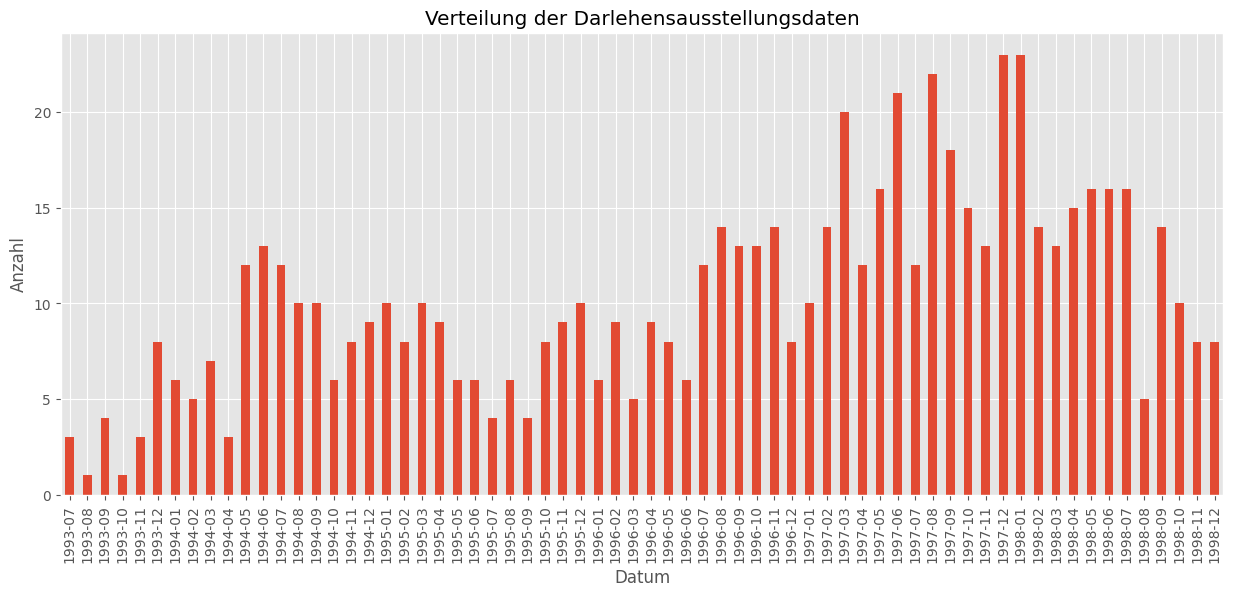

In [57]:
# plot distribution of date
plt.figure(figsize=(15, 6))
loan["date"].dt.to_period("M").value_counts().sort_index().plot(kind="bar")
plt.title("Verteilung der Darlehensausstellungsdaten")
plt.xlabel("Datum")
plt.ylabel("Anzahl")
plt.show()

### Dauer
Hier ersichtlich ist die Verteilung der Dauer der Darlehen. Sie ist fast gleichverteilt über die 5 möglichen Optionen. 

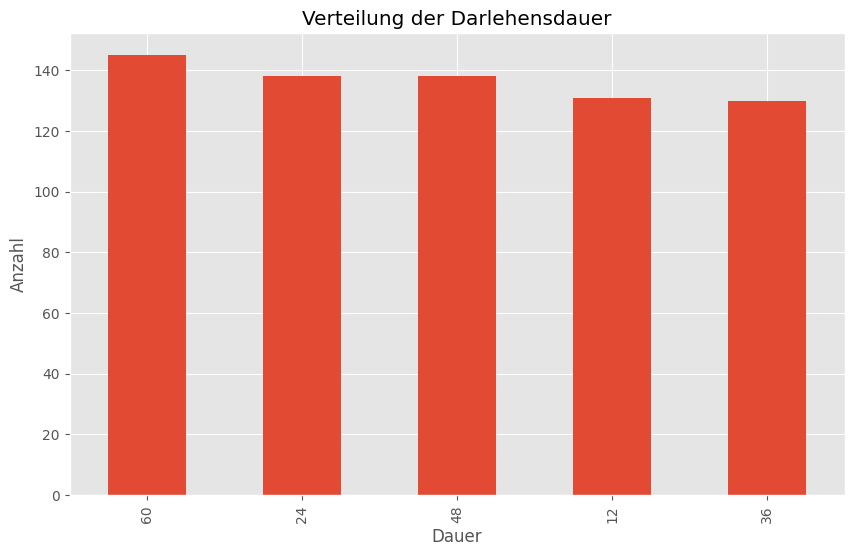

In [58]:
# plot duration distribution
plt.figure(figsize=(10, 6))
loan["duration"].value_counts().plot(kind="bar")
plt.title("Verteilung der Darlehensdauer")
plt.xlabel("Dauer")
plt.ylabel("Anzahl")
plt.show()

### Betrag
Hier dargestellt ist die Verteilung der Darlehensbeträge. Nur wenige Darlehensbeträge sind höher als 400000 wobei die meisten um die 100000 betragen. 

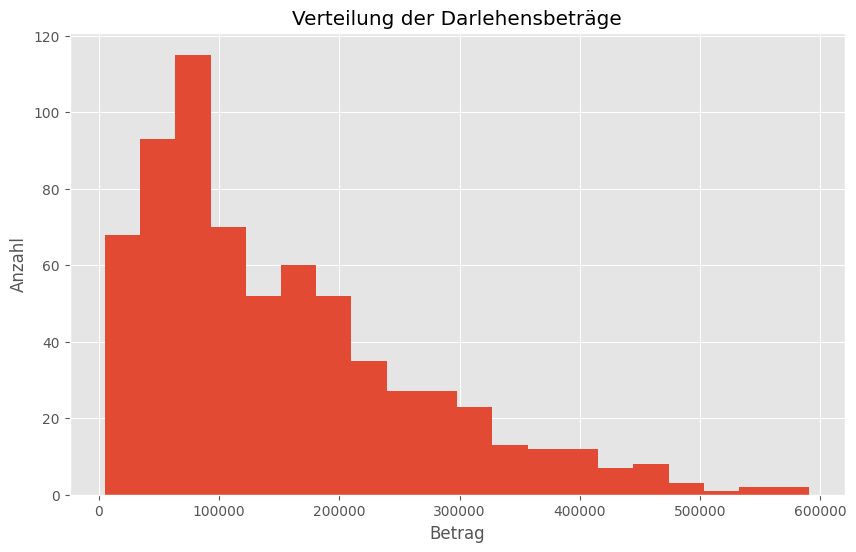

In [59]:
# plot amount
plt.figure(figsize=(10, 6))
loan["amount"].plot(kind="hist", bins=20)
plt.title("Verteilung der Darlehensbeträge")
plt.xlabel("Betrag")
plt.ylabel("Anzahl")
plt.show()

### Status
Der nachfolgende Plot zeigt die Klassenverteilung vom Darlehensstatus. Die meisten (~400) sind laufend und ok, rund 200 sind abgeschlossen, die Kunden von ~50 Darlehen sind verschuldet und etwas weniger wurden abgeschlossen, ohne fertig abbezahlt worden zu sein.  

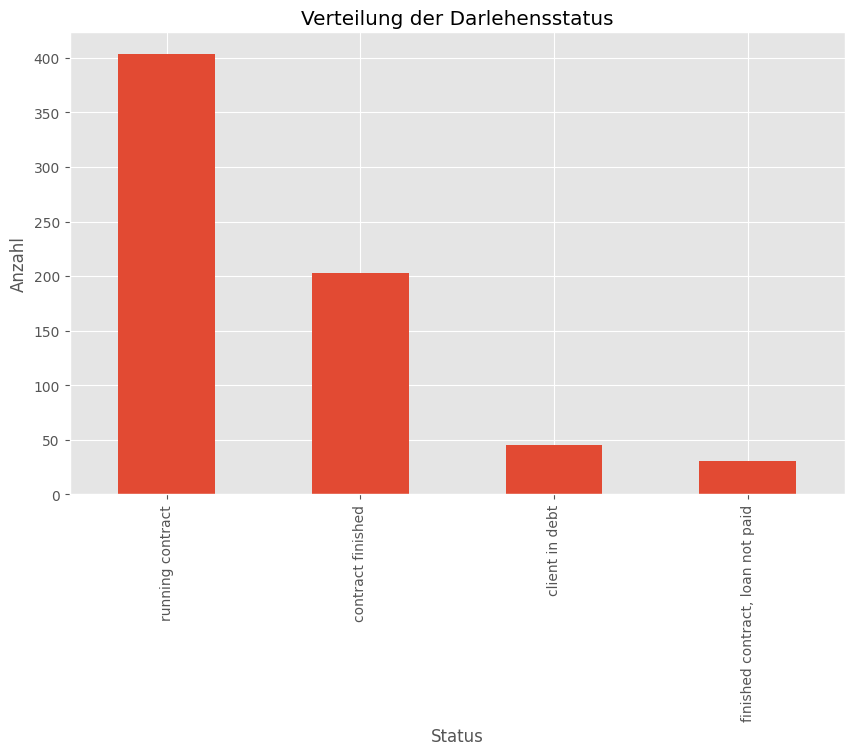

In [60]:
# plot status distribution
plt.figure(figsize=(10, 6))
loan["status"].value_counts().plot(kind="bar")
plt.title("Verteilung der Darlehensstatus")
plt.xlabel("Status")
plt.ylabel("Anzahl")
plt.show()

### Zahlungen
Hier ersichtlich ist die Verteilung der monatlichen Zahlungen der Darlehen. Die kleinste monatliche Zahlung beträgt 304 und die höchste 9910.

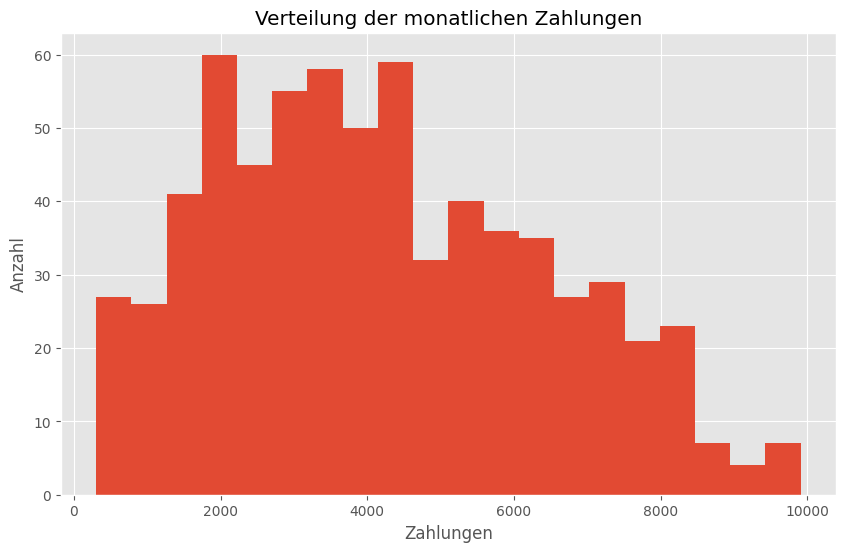

In [61]:
# plot payments
plt.figure(figsize=(10, 6))
loan["payments"].plot(kind="hist", bins=20)
plt.title("Verteilung der monatlichen Zahlungen")
plt.xlabel("Zahlungen")
plt.ylabel("Anzahl")
plt.show()

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/loan.html) entnommen werden.

In [62]:
# Assign the resulting DataFrame to a dictionary for storage
data_frames["loan.csv"] = loan

In [63]:
# %%capture
# svReport_loan = sv.analyze(loan)
# svReport_loan.show_html(filepath="./reports/loan.html", open_browser=False)

## Order
[//]: # (-.- .tabset)

Der Datensatz `order.csv` beinhaltet 6471 Observationen mit den folgenden Informationen über die Daueraufträge eines Kontos:  

- `order_id`: die Nummer des Dauerauftrags,  
- `account_id`: die Kontonummer von welchem der Auftrag stammt,  
- `bank_to`: die empfangende Bank,  
- `account_to`: das empfangende Konto,  
- `amount`: der Betrag,  
- `k_symbol`: die Art des Auftrags (Versicherungszahlung, Haushalt, Leasing, Darlehen)


In [64]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    6471 non-null   int64  
 1   account_id  6471 non-null   int64  
 2   bank_to     6471 non-null   object 
 3   account_to  6471 non-null   int64  
 4   amount      6471 non-null   float64
 5   k_symbol    6471 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 303.5+ KB


In [65]:
print("Anzahl fehlender Werte:", sum(order.isnull().sum()))
print("Anzahl duplizierter Einträge:", order.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Aufbereitung
Auch für `order.csv` werden die Kategorien zunächst übersetzt und fehlende Werte mit der Kategorie `unknown` ersetzt. Es bestehen deutlich mehr Daueraufträge als Bankkontos, was darauf hindeutet, dass ein Bankkonto mehrere Daueraufträge eingerichtet haben kann. Zur weiteren Verarbeitung der Daten wird das Format so geändert, dass pro Konto ein `order`-Eintrag existiert.  

In [66]:
# Kategorien übersetzen und fehlende Werte mit "unknown" füllen
order["k_symbol"] = (
    order["k_symbol"]
    .map(
        {
            "POJISTNE": "insurance_payment",
            "SIPO": "household",
            "UVER": "loan_payment",
            "LEASING": "leasing",
        }
    )
    .fillna("unknown")
)

order["k_symbol"] = order["k_symbol"].astype("category")

In [67]:
# Merge with 'account_id_df' to ensure all accounts are represented
order = pd.merge(account[["account_id"]], order, on="account_id", how="left")

# After merging, fill missing values that may have been introduced
order["k_symbol"] = order["k_symbol"].fillna("unknown")
order["amount"] = order["amount"].fillna(0)
order["has_order"] = ~order.isna().any(axis=1)

orders_pivot = order.pivot_table(
    index="account_id",
    columns="k_symbol",
    values="amount",
    aggfunc="sum",
    observed=False,
)

# Add prefix to column names
orders_pivot.columns = orders_pivot.columns

orders_pivot = orders_pivot.reset_index()

# NaN to 0
orders_pivot = orders_pivot.fillna(0)
# Sample 5 random rows from the merged DataFrame
orders_pivot.sample(n=5)

k_symbol,account_id,household,insurance_payment,leasing,loan_payment,unknown
4196,7542,3683.0,0.0,0.0,9847.0,3389.0
2949,3102,6722.0,0.0,0.0,0.0,0.0
2244,2362,2259.0,0.0,0.0,0.0,0.0
806,847,0.0,0.0,0.0,0.0,0.0
2448,2574,9546.0,0.0,0.0,0.0,0.0


### Empfangende Bank
Die Verteilung der empfangenden Banken ist ziemlich ausgeglichen, wobei in 742 Observationen diese Angabe fehlt.  

### Empfangendes Konto
Auch bei den empfangenden Konten scheint es keine auffällige Konzentration bei wenigen Konten zu geben und bei 742 Observationen fehlt die Angabe ebenfalls.  

### Betrag
Der Betrag bewegt sich im Bereich zwischen 0 - 14882 mit einem Mittelwert von 2943 und einem Median von 2249. Die Verteilung ist also stark rechtsschief

### Art
Die meisten Daueraufträge sind betreffend dem Haushalt eingerichtet worden (3502), die wenigsten für Leasing (341).  

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/order.html) entnommen werden.

In [68]:
# Assuming data_frames is a dictionary for storing DataFrames
data_frames["order.csv"] = orders_pivot

In [69]:
# %%capture
# svReport_order = sv.analyze(order)
# svReport_order.show_html(filepath="./reports/order.html", open_browser=False)

## Trans
[//]: # (-.- .tabset)

Der Datensatz `trans.csv` beinhaltet 1056320 Observationen mit den folgenden Informationen über die Transaktionen eines Kontos:  

- `trans_id`: die ID der Transaktion,  
- `account_id`: die Kontonummer des ausführenden Kontos,  
- `date`: das Datum,  
- `type`: der Typ (Einzahlung, Bezug),  
- `operation`: die Art der Transaktion (Bezug Kreditkarte, Bareinzahlung, Bezug über eine andere Bank, Bezug Bar, Überweisung)  
- `amount`: der Betrag der Transaktion,  
- `balance`: der Kontostand nach ausführung der Transaktion,  
- `k_symbol`: die Klassifikation der Transaktion (Versicherungszahlung, Kontoauszug, Zinsauszahlung, Zinszahlung bei negativem Kontostand, Haushalt, Pension, Darlehensauszahlung),  
- `bank`: die empfangende Bank und   
- `account`: das empfangende Bankkonto


In [70]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   trans_id    1056320 non-null  int64  
 1   account_id  1056320 non-null  int64  
 2   date        1056320 non-null  object 
 3   type        1056320 non-null  object 
 4   operation   873206 non-null   object 
 5   amount      1056320 non-null  float64
 6   balance     1056320 non-null  float64
 7   k_symbol    574439 non-null   object 
 8   bank        273508 non-null   object 
 9   account     295389 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 80.6+ MB


In [71]:
print("Anzahl fehlender Werte:", sum(trans.isnull().sum()))
print("Anzahl duplizierter Einträge:", trans.duplicated().sum())

Anzahl fehlender Werte: 2208738
Anzahl duplizierter Einträge: 0


### Aufbereitung
Die Kategorien für `type`, `operation` und `k_symbol` wurden übersetzt und die Datentypen korrigiert.  

In [72]:
trans["date"] = pd.to_datetime(trans["date"], format="%y%m%d")

# Update 'type' column
trans["type"] = trans["type"].replace(
    {"PRIJEM": "credit", "VYDAJ": "withdrawal", "VYBER": "withdrawal"}
)
trans["type"] = trans["type"].astype("category")

# Update 'operation' column
trans["operation"] = trans["operation"].replace(
    {
        "VYBER KARTOU": "credit card withdrawal",
        "VKLAD": "credit in cash",
        "PREVOD Z UCTU": "collection from another bank",
        "VYBER": "cash withdrawal",
        "PREVOD NA UCET": "remittance to another bank",
    }
)
trans["operation"] = trans["operation"].astype("category")

# Update 'k_symbol' column
trans["k_symbol"] = trans["k_symbol"].replace(
    {
        "POJISTNE": "insurance payment",
        "SLUZBY": "statement payment",
        "UROK": "interest credited",
        "SANKC. UROK": "sanction interest if negative balance",
        "SIPO": "household payment",
        "DUCHOD": "pension credited",
        "UVER": "loan payment",
    }
)
trans["k_symbol"] = trans["k_symbol"].astype("category")

# negate the amount if type is credit
trans.loc[trans["type"] == "withdrawal", "amount"] = trans.loc[
    trans["type"] == "withdrawal", "amount"
] * (-1)

In [73]:
# Sample 5 random rows from the DataFrame
trans.sample(n=5)

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
272711,3567306,1118,1996-01-31,credit,NaN,66.1,14408.7,interest credited,NaN,NaN
303163,746862,2548,1996-04-09,credit,credit in cash,5118.0,33586.5,NaN,NaN,NaN
465989,399130,1359,1997-01-15,credit,credit in cash,2600.0,36127.9,NaN,NaN,NaN
279576,1311277,4478,1996-02-13,credit,credit in cash,24248.0,66671.6,NaN,NaN,NaN
680946,3469476,4264,1997-10-31,credit,NaN,206.6,49287.4,interest credited,NaN,NaN


### Zeitliche Entwicklung eines Kontos

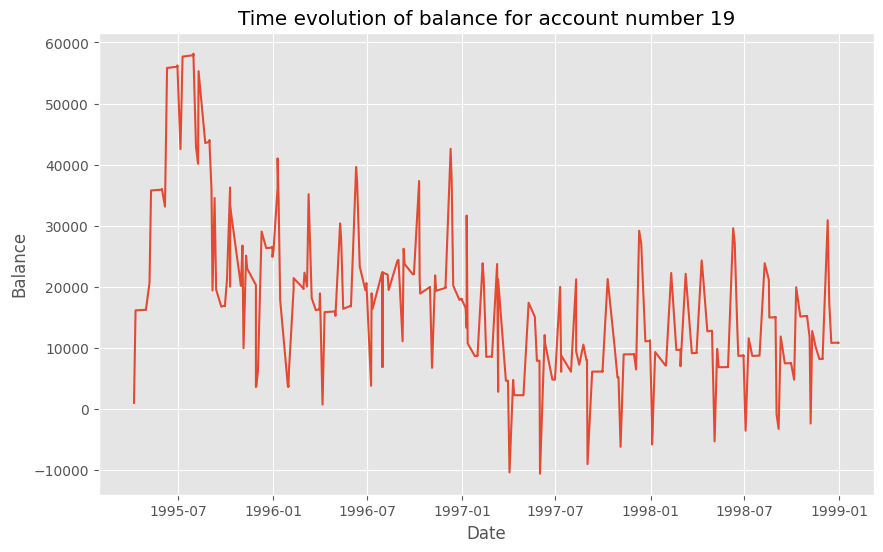

In [74]:
# Plot Zeitliche Entwicklung des Konto-Saldos für die Konto nummer 19
account_19 = trans[trans["account_id"] == 19].copy()  # Create a copy of the DataFrame
# Ensure the date column is in datetime format
account_19["date"] = pd.to_datetime(account_19["date"])

# Sort the values by date
account_19 = account_19.sort_values("date")

plt.figure(figsize=(10, 6))
plt.plot(account_19["date"], account_19["balance"])
plt.title("Time evolution of balance for account number 19")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.show()

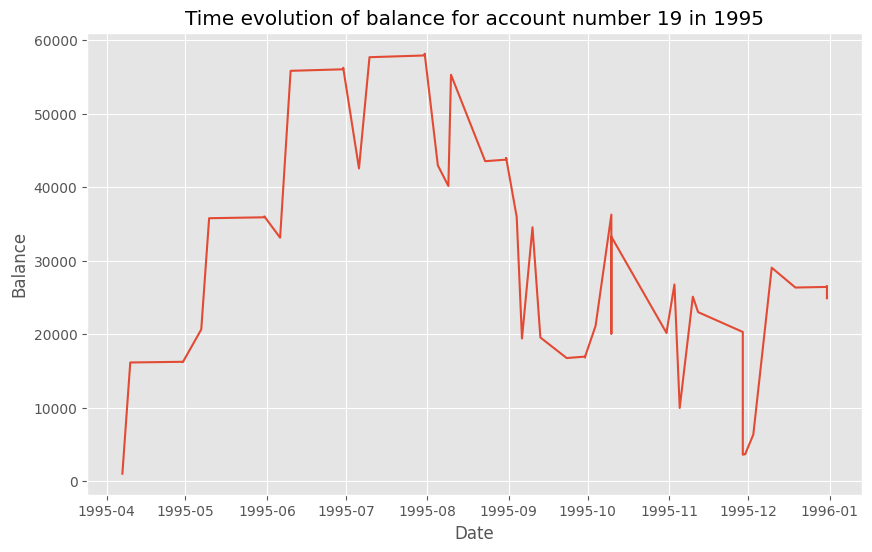

In [75]:
# zoom the year 1995 of the plot
account_19_1995 = account_19[account_19["date"].dt.year == 1995]
# plot it
plt.figure(figsize=(10, 6))
plt.plot(account_19_1995["date"], account_19_1995["balance"])
plt.title("Time evolution of balance for account number 19 in 1995")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.show()

# Wee see that there is a steep line in 1995-10 so there are two transactions, this we have to clean.

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/trans.html) entnommen werden.

In [76]:
# Assign to a dictionary if needed (similar to list assignment in R)
data_frames["trans.csv"] = trans

In [77]:
# %%capture
# svReport_trans = sv.analyze(trans)
# svReport_trans.show_html(filepath="./reports/trans.html", open_browser=False)

# Kombinieren der Daten zu einem Modellierungsdatensatz
Im nachfolgenden Abschnitt werden die Daten zu statischen (Kunden-) Daten und transaktionellen (Bankdienstleistungs-) Daten kombiniert um diese anschliessend zu einem Datensatz für die Modellierung zusammenzufügen.  
 
## Stammdaten
Die aufbereiteten Stammdaten aus den Dateien 

- `disp.csv`  
- `account.csv`  
- `client.csv`  
- `card.csv`  
- `loan.csv`  
- `order.csv`  
- `districts.csv`  

werden nachfolgend zu einem Datensatz kombiniert. 

In [78]:
# merge dataframes
static_data = (
    data_frames["disp.csv"]
    .merge(data_frames["account.csv"], on="account_id", validate="1:1", how="left")
    .merge(
        data_frames["client.csv"],
        on="client_id",
        validate="1:1",
        suffixes=("_account", "_client"),
        how="left",
    )
    .merge(
        data_frames["card.csv"],
        on="disp_id",
        validate="1:1",
        suffixes=("_disp", "_card"),
        how="left",
    )
    .merge(
        data_frames["loan.csv"],
        on="account_id",
        suffixes=("_account", "_loan"),
        validate="1:1",
        how="left",
    )
    .merge(data_frames["order.csv"], on="account_id", validate="1:1", how="left")
    .merge(
        data_frames["district.csv"].add_suffix("_account"),
        left_on="district_id_account",
        right_on="district_id_account",
        validate="m:1",
        how="left",
    )
    .merge(
        data_frames["district.csv"].add_suffix("_client"),
        left_on="district_id_client",
        right_on="district_id_client",
        validate="m:1",
        how="left",
    )
)

In [79]:
static_data["has_card"] = ~static_data["card_id"].isna()

In [80]:
static_data["type_card"] = static_data["type_card"].cat.add_categories(["none"])
static_data.loc[static_data["card_id"].isna(), "type_card"] = "none"

In [81]:
# get static_data status categories
static_data["status"] = static_data["status"].cat.add_categories(["none"])
static_data.loc[static_data["status"].isna(), "status"] = "none"

In [82]:
static_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 56 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   disp_id                                 4500 non-null   int64         
 1   client_id                               4500 non-null   int64         
 2   account_id                              4500 non-null   int64         
 3   type_disp                               4500 non-null   category      
 4   district_id_account                     4500 non-null   int64         
 5   frequency                               4500 non-null   category      
 6   date_account                            4500 non-null   datetime64[ns]
 7   district_id_client                      4500 non-null   int64         
 8   gender                                  4500 non-null   category      
 9   birth_day                               4500 non-nul

In [83]:
print("Anzahl duplizierter Einträge:", static_data.duplicated().sum())

Anzahl duplizierter Einträge: 0


In [84]:
# fillna for payments, duration, amount
static_data["payments"] = static_data["payments"].fillna(0)
static_data["duration"] = static_data["duration"].fillna(0)
static_data["amount"] = static_data["amount"].fillna(0)

Damit wird ein Datensatz mit 4500 individuellen Kunden und 56 Spalten erzeugt. 892 dieser Kunden besitzen eine Kreditkarte und 682 haben einen Kredit aufgenommen. 

## Entfernen der Junior Karteninhaber
Kunden im jugendlichen Alter sind speziell interessante Kunden für eine Bank, da diese grundsätzlich noch keine bis wenige Bankdienstleistungen beziehen und somit flexibel sind. Es ist deshalb sehr vorteilhaft für ein Unternehmen diese für sich zu gewinnen, weshalb viele Banken für solche Kunden ganz spezifische Prozesse definieren. Das in dieser Aufgabenstellung gewünschte Modell würde in so einem Prozess nicht eingesetzt werden, weshalb die jugendlichen Kunden nachfolgend aus dem Datensatz entfernt werden.    

In [85]:
num_accounts_before = len(static_data)
# # Filter rows where 'card_type' does not contain 'junior' (case insensitive)
static_data = static_data[
    ~static_data["type_card"].str.contains("junior", case=False, na=False)
]
num_accounts_after = len(static_data)
num_junior_cards = num_accounts_before - num_accounts_after
print(f"Number of junior cards removed: {num_junior_cards}")

Number of junior cards removed: 145


Durch diese Entfernung wurden 145 Kunden entfernt. 

## Bewegungsdaten
Um einen Datensatz zu erhalten, bei welchem jede Zeile eine Observation repräsentiert müssen die Transaktionen pro Kunde entsprechend aufgerollt werden. Das bedeutet, ein vordefiniertes Zeitfenster vor dem zu modellierenden Event zu definieren und die darin enthaltenen Daten in einer Zeile zu aggregieren. Das gesuchte Zeitfenster beinhaltet bestenfalls saisonale Gegebenheiten und stets einen Lag-Zeitraum, der die Verzögerung der Kaufentscheidung und Ausführung des Auftrags aufzeichnen soll. 
Hier wird ein Rollup-Fenster inklusive Lag von 13 Monaten eingesetzt. 

### Käufer
Für Kunden, die bereits eine Kreditkarte besitzen, ist es unkompliziert, das Rollup-Fenster zu identifizieren. 


In [86]:
# select all transactions from trans from date 1995-03-16 and account_id 150
trans[(trans["date"] == "1995-03-16") & (trans["account_id"] == 150)]

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
148637,44703,150,1995-03-16,credit,credit in cash,900.0,2800.0,NaN,NaN,NaN
148638,44714,150,1995-03-16,credit,credit in cash,1900.0,1900.0,NaN,NaN,NaN


Aus dieser Tabelle ersichtlich ist, dass für den Kunden 150 zum Datum der Eröffnung des Kontos mehrere Transaktionen vorhanden sind und dass wenn die Beträge von dem Tag aufsummiert werden, der korrekte Kontostand resultiert (1900 + 900 = 2800). Deshalb wird nachfolgend davon ausgegangen, dass die Aufsummierung der Transaktionsbeträge zum korrekten Kontostand führt. 

In [87]:
# sort dataframe trans by account_id and date
first_row_per_account = trans.groupby("account_id")

# select rows where amount == balance
first_row_per_account = first_row_per_account.apply(
    lambda x: x[x["amount"] == x["balance"]].iloc[0], include_groups=False
).reset_index()

In [88]:
# show that there's one row per unique account_id in trans
first_row_per_account["account_id"].nunique() == trans["account_id"].nunique()

True

In [89]:
first_row_per_account.query("amount != balance")

,account_id,trans_id,date,type,operation,amount,balance,k_symbol,bank,account


Mit dem obigen Code wird zudem sichergestellt, dass diese Gegebenheit für alle Kunden gilt. Nachfolgend werden die Transaktionen aggregiert, sodass die Spalten  

- `volume`: das Volumen, also die Summe der Ein- und Ausgaben auf dem Konto,  
- `credit`: die Summe der Einnahmen,  
- `withdrawal`: die Summe der Ausgaben,  
- `n_transactions`: die Anzahl der getätigten Transaktionen und  
- `balance`: der Kontostand

pro Monat entstehen. Dieser Datensatz wird dann mithilfe der nachfolgend definierten Funktion `rollup_credit_card` aufgerollt. 

In [90]:
# Extract year and month from date to a new column 'year_month'
trans["year_month"] = trans["date"].dt.to_period("M")

# Group by 'account_id' and 'month', and calculate the sum of 'amount', 'credit', 'withdrawal' and 'n_transactions'
transactions_monthly = (
    trans.groupby(["account_id", "year_month"])
    .agg(
        volume=("amount", "sum"),
        credit=("amount", lambda x: x[x > 0].sum()),
        withdrawal=("amount", lambda x: x[x < 0].sum()),
        n_transactions=("amount", "count"),
    )
    .reset_index()
)

# Calculate cumulative sum of 'volume' for each account
transactions_monthly["balance"] = transactions_monthly.groupby("account_id")[
    "volume"
].cumsum()

In [91]:
# count unique account_ids in transactions_monthly
print(transactions_monthly["account_id"].nunique())
num_accounts_before = transactions_monthly["account_id"].nunique()

4500


In [92]:
def rollup_credit_card(trans_monthly, account_card_issue_dates):
    # Add issue date and calculate months since card issue
    trans_monthly = pd.merge(trans_monthly, account_card_issue_dates, on="account_id")

    trans_monthly["months_before_card_issue"] = [
        (issued - year_month).n
        for issued, year_month in zip(
            trans_monthly["issued"], trans_monthly["year_month"]
        )
    ]

    # select only where months_before_card_issue > 0 and <= 13
    trans_monthly = trans_monthly[
        (trans_monthly["months_before_card_issue"] > 0)
        & (trans_monthly["months_before_card_issue"] <= 13)
    ]

    trans_monthly = trans_monthly.groupby("account_id").filter(lambda x: len(x) == 13)

    # Pivot wider
    trans_monthly = trans_monthly.pivot_table(
        index="account_id",
        columns="months_before_card_issue",
        values=["volume", "credit", "withdrawal", "n_transactions", "balance"],
    )
    trans_monthly.reset_index(inplace=True)
    trans_monthly.columns = [
        "_".join(str(i) for i in col) for col in trans_monthly.columns
    ]
    # rename account_id_ to account_id
    trans_monthly = trans_monthly.rename(columns={"account_id_": "account_id"})

    return trans_monthly

In [93]:
buyers = static_data[static_data["has_card"]]

# print number of buyers
print(buyers["account_id"].nunique())

747


In [94]:
transactions_rolled_up_buyers = rollup_credit_card(
    transactions_monthly, buyers.loc[:, ["account_id", "issued"]]
)

transactions_rolled_up_buyers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 66 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   account_id         568 non-null    int64  
 1   balance_1          568 non-null    float64
 2   balance_2          568 non-null    float64
 3   balance_3          568 non-null    float64
 4   balance_4          568 non-null    float64
 5   balance_5          568 non-null    float64
 6   balance_6          568 non-null    float64
 7   balance_7          568 non-null    float64
 8   balance_8          568 non-null    float64
 9   balance_9          568 non-null    float64
 10  balance_10         568 non-null    float64
 11  balance_11         568 non-null    float64
 12  balance_12         568 non-null    float64
 13  balance_13         568 non-null    float64
 14  credit_1           568 non-null    float64
 15  credit_2           568 non-null    float64
 16  credit_3           568 non

In [95]:
# calculate the number of buyers lost by rolling up
lost_buyers = buyers[
    ~buyers["account_id"].isin(transactions_rolled_up_buyers["account_id"])
]
lost_buyers = lost_buyers["account_id"].nunique()
print(lost_buyers)

179


Und so entsteht ein Datensatz, welcher für 568 Kreditkartenkäufer die Merkmale `balance`, `credit`, `n_transactions`, `volume` und `withdrawal` für alle 13 Monate des Rollup-Fensters inklusive Lag beinhaltet. 

### Nicht-Käufer
Um die Transaktionen der Nicht-Käufer analog zu verarbeiten, wird ein fiktives Kaufdatum benötigt, welches als Ausgangslage für die Aufrollung dient.

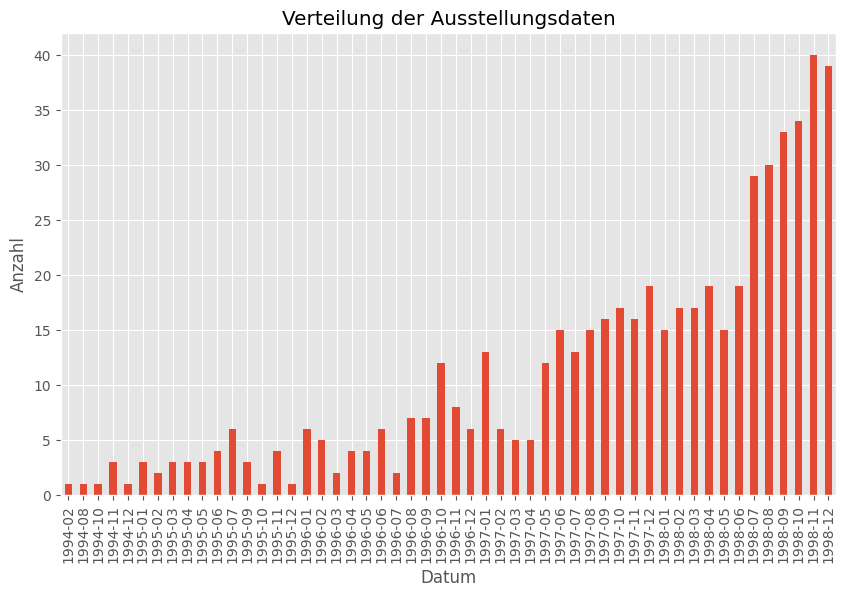

In [96]:
# plot the issue date distribution of the buyers that where rolled up (586)
merged_data = transactions_rolled_up_buyers.merge(
    buyers, how="left", left_on="account_id", right_on="account_id"
)
plt.figure(figsize=(10, 6))
merged_data["issued"].value_counts().sort_index().plot(kind="bar")
plt.title("Verteilung der Ausstellungsdaten")
plt.xlabel("Datum")
plt.ylabel("Anzahl")
plt.show()

Hier dargestellt ist die Verteilung der Ausstellungsdaten der Kreditkarten. Zu erkennen ist ein klarer aufwärtstrend.

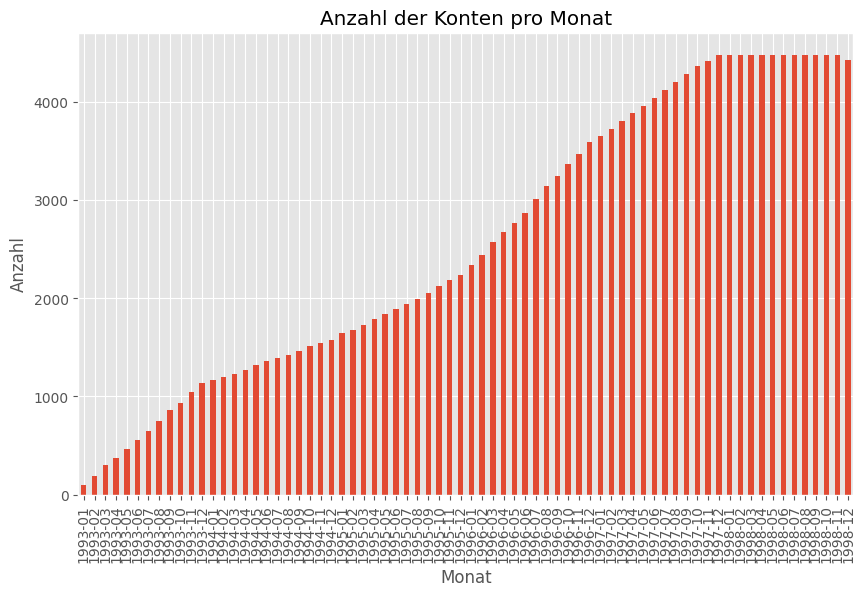

In [97]:
# from transactions_monthly plot the number of distinct account ids per month
plt.figure(figsize=(10, 6))
transactions_monthly["year_month"].value_counts().sort_index().plot(kind="bar")
plt.title("Anzahl der Konten pro Monat")
plt.xlabel("Monat")
plt.ylabel("Anzahl")
plt.show()

In [98]:
# calculate the correlation between transactions_monthly["year_month"] and merged_data["issued"].value_counts()
transactions_monthly["year_month"].value_counts().sort_index().corr(
    merged_data["issued"].value_counts().sort_index()
)

0.7837318295574054

Hier dargestellt ist die Verteilung der Anzahl von eröffneten Konten pro Monat. Der hier beobachtete Aufwärtstrend der Anzahl erstellter Konten könnte ein maßgebender Einflussfaktor der Anzahl ausgestellter Kreditkarten pro Monat sein. Der Korrelationskoeffizient von 0.78 unterstreicht diese Beobachtung. Wir gehen davon aus, dass diese Gegebenheit von einem Klassifikationsmodell schnell overfitted wird, weshalb wir nachfolgend ein random sampling einsetzen, um das fiktive Issue-Date von Nicht-Käufern zu definieren.

In [99]:
def rollup_non_credit(trans_monthly, non_buyers, range):
    # set seed
    np.random.seed(43)
    # for each non buyer, find the date of the first transaction
    first_transaction_dates = (
        trans_monthly.groupby("account_id")["year_month"].min().reset_index()
    )
    first_transaction_dates.columns = ["account_id", "first_transaction_date"]

    # merge the first transaction dates with the non_buyers DataFrame
    non_buyers = non_buyers.merge(first_transaction_dates, on="account_id", how="left")

    # randomly sample a date from the range as issue date for each non buyer making sure that the random date is after the first transaction of the non buyer
    non_buyers["issued"] = non_buyers["first_transaction_date"].apply(
        lambda x: np.random.choice(range, 1)[0]
    )

    non_buyers_rolled_up = rollup_credit_card(
        trans_monthly, non_buyers.loc[:, ["account_id", "issued"]]
    )
    return non_buyers_rolled_up, non_buyers

In [100]:
# get the list of issue dates of buyers
issue_dates_buyers = buyers["issued"].unique()
n_non_buyers = static_data[~static_data["has_card"]]["account_id"].nunique()
transactions_rolled_up_non_buyers, non_buyers = rollup_non_credit(
    transactions_monthly, static_data[~static_data["has_card"]], issue_dates_buyers
)
transactions_rolled_up_non_buyers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 66 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   account_id         1684 non-null   int64  
 1   balance_1          1684 non-null   float64
 2   balance_2          1684 non-null   float64
 3   balance_3          1684 non-null   float64
 4   balance_4          1684 non-null   float64
 5   balance_5          1684 non-null   float64
 6   balance_6          1684 non-null   float64
 7   balance_7          1684 non-null   float64
 8   balance_8          1684 non-null   float64
 9   balance_9          1684 non-null   float64
 10  balance_10         1684 non-null   float64
 11  balance_11         1684 non-null   float64
 12  balance_12         1684 non-null   float64
 13  balance_13         1684 non-null   float64
 14  credit_1           1684 non-null   float64
 15  credit_2           1684 non-null   float64
 16  credit_3           1684 

So finden wir 1684 aufgerollte Datensätze für Nicht-Käufer. 

In [101]:
non_buyers_lost = (
    n_non_buyers - transactions_rolled_up_non_buyers["account_id"].nunique()
)
print(non_buyers_lost)


1924


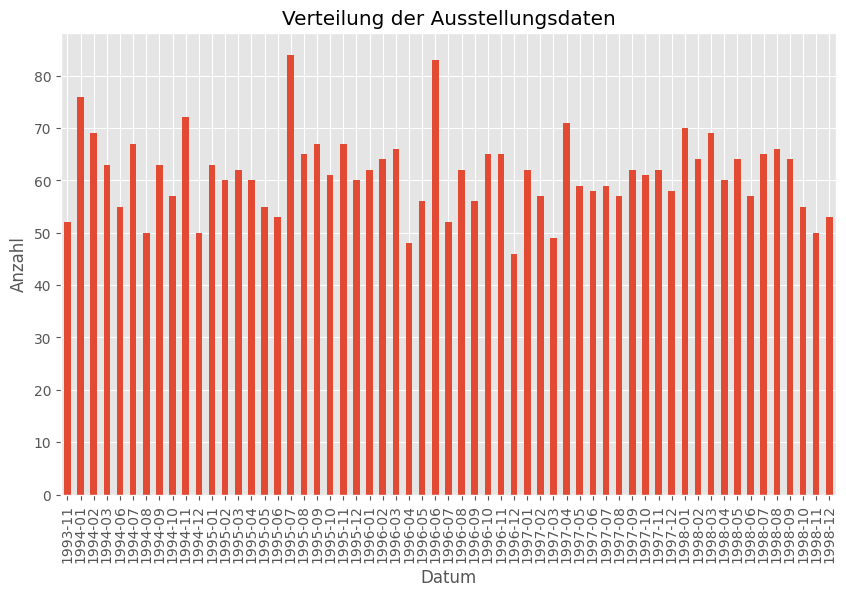

In [102]:
# plot the issue date distribution of the non-buyers that where rolled up
plt.figure(figsize=(10, 6))
non_buyers["issued"].value_counts().sort_index().plot(kind="bar")
plt.title("Verteilung der Ausstellungsdaten")
plt.xlabel("Datum")
plt.ylabel("Anzahl")
plt.show()

## Zusammenfügen der Daten
Nachfolgend werden die Stammdaten mit den aufgerollten Bewegungsdaten zum Modellierungsdatensatz kombiniert.

In [103]:
transactions_rolled_up = pd.concat(
    [transactions_rolled_up_buyers, transactions_rolled_up_non_buyers]
)
# merge transactions_rolled_up and static data
X = pd.merge(static_data, transactions_rolled_up, on="account_id")

### Entfernen von minderjährigen Kunden
Kunden die zum Zeitpunkt des Erwerbs der Kreditkarte minderjährig waren, müssen entfernt werden, da diese Zielgruppe, wie bereits beschrieben, nicht modelliert werden soll.

In [104]:
num_before_underage_removal = X["account_id"].nunique()
X["issued"] = X["issued"].fillna(non_buyers["issued"])
X["issued"] = X["issued"].dt.to_timestamp()

time_to_compare = pd.Timedelta(days=6970)

# Filter underage accounts
X = X[(X["issued"] - X["birth_day"]) >= time_to_compare]

# Calculate the number of accounts after filtering
num_accounts_after = X["account_id"].nunique()

# Calculate the number of underage accounts
num_underage_accounts = num_before_underage_removal - num_accounts_after
num_underage_accounts

120

120 Kunden werden durch diesen Schritt entfernt.

In [105]:
y = X["has_card"]

X = X.drop(
    columns=[
        "has_card",
        "card_id",
        "issued",
        "type_card",
        "loan_id",
        "date_loan",
        "disp_id",
        "client_id",
        "district_id_account",
        "birth_day",
        "type_disp",
    ]
)
# convert "date_account" to "days active"
X["date_account"] = (X["date_account"] - X["date_account"].min()).dt.days

In [106]:
# show NaNs in X
X.isnull().sum()

account_id                                0
frequency                                 0
date_account                              0
district_id_client                        0
gender                                    0
age                                       0
amount                                    0
duration                                  0
payments                                  0
status                                    0
household                                 0
insurance_payment                         0
leasing                                   0
loan_payment                              0
unknown                                   0
district_name_account                     0
region_account                            0
num_of_habitat_account                    0
num_of_small_town_account                 0
num_of_medium_town_account                0
num_of_big_town_account                   0
num_of_bigger_town_account                0
num_of_city_account             

Zu sehen ist, dass der Datensatz komplett ist, also keine fehlenden Werte aufweist.

## Explorative Datenanalyse des Modellierungssatzes
Nachfolgend werden diverse Askepte des zusammengefügten Datensatzes untersucht
### Entfernte Konten
In der Vorverarbeitung werden diverse Kundenkonten aus dem Datensatz entfernt. Die folgende Darstellung zeigt auf, wie viele in welchem Schritt entfernt werden.

In [107]:
num_junior_cards, lost_buyers, non_buyers_lost, num_underage_accounts, X.shape[0]

(145, 179, 1924, 120, 2132)

In [108]:
waterfall_data = {
    "step": [
        "Initial",
        "Junior Card Holders",
        "Lost Buyers",
        "Non-Buyers",
        "Underage Clients",
        "Final",
    ],
    "count": [
        4500,
        -num_junior_cards,
        -lost_buyers,
        -non_buyers_lost,
        -num_underage_accounts,
        X.shape[0],
    ],
}

waterfall_df = pd.DataFrame(waterfall_data)

blank = waterfall_df["count"].cumsum().shift(1).fillna(0)
step = blank.reset_index(drop=True).repeat(3).shift(-1)
step[1::3] = np.nan
blank[5] = 0

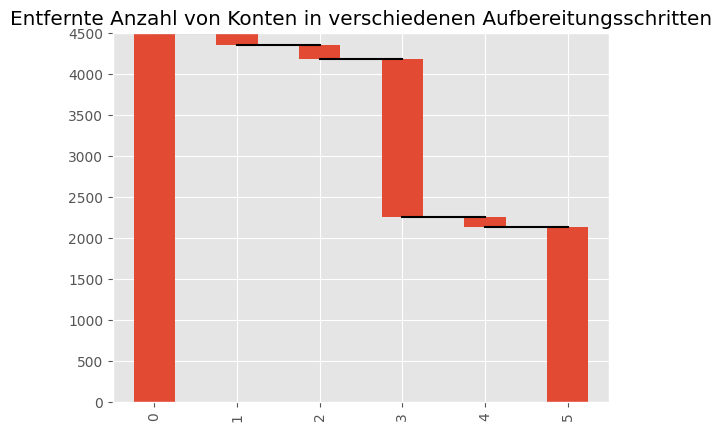

In [109]:
my_plot = waterfall_df.plot(
    kind="bar",
    stacked=True,
    bottom=blank,
    legend=False,
    title="Entfernte Anzahl von Konten in verschiedenen Aufbereitungsschritten",
)
my_plot.plot(step.index, step.values, "k")


In [110]:
display(waterfall_df)

,step,count
0,Initial,4500
1,Junior Card Holders,-145
2,Lost Buyers,-179
3,Non-Buyers,-1924
4,Underage Clients,-120
5,Final,2132


Insgesamt werden also 2368 Konten in der Vorberarbeitung entfernt. 
### Verteilung Kartenbesitzer
Nachfolgend wird die Verteilung der Kartenbesitzer aufgezeigt.

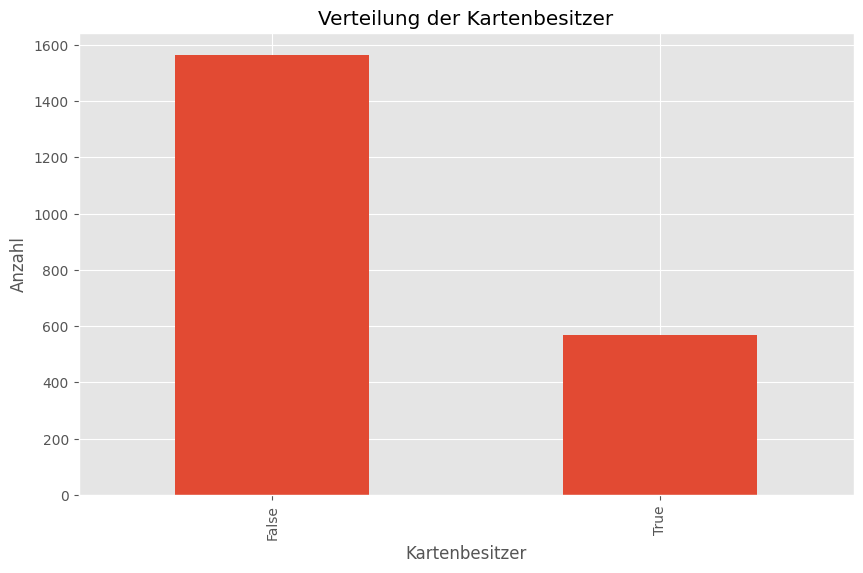

In [111]:
# plot distribution of has_card
plt.figure(figsize=(10, 6))
y.value_counts().plot(kind="bar")
plt.title("Verteilung der Kartenbesitzer")
plt.xlabel("Kartenbesitzer")
plt.ylabel("Anzahl")
plt.show()

Klar ersichtlich ist, dass es deutlich mehr Nicht-Kartenbesitzer als Kartenbesitzer gibt. Unbalancierten Daten erschweren die Modellierung erheblich, weshalb nachfolgend SMOTE (Synthetic Minority Over-sampling Technique) eingesetzt wird, um die Daten zu balancieren.

In [112]:
from imblearn.over_sampling import SMOTE

# x get dummy variables for category
X = pd.get_dummies(X, drop_first=True)

sm = SMOTE(random_state=43)
X_res, y_res = sm.fit_resample(X, y)

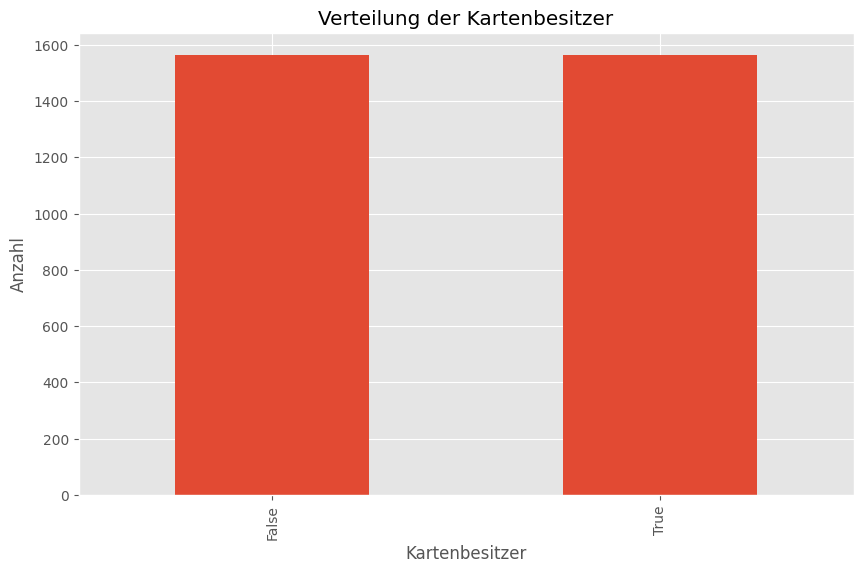

In [113]:
# plot distribution of has_card
plt.figure(figsize=(10, 6))
y_res.value_counts().plot(kind="bar")
plt.title("Verteilung der Kartenbesitzer")
plt.xlabel("Kartenbesitzer")
plt.ylabel("Anzahl")
plt.show()

Durch den Einsatz von SMOTE konnte der Datensatz ausbalanciert werden.
### Konten 14 und 18
In der Aufgabenbeschreibung wurde explizit verlangt, die Konten 14 und 18 zu untersuchen. Nachfolgend dargestellt ist der Saldo und das Volumen der beiden Konten. 

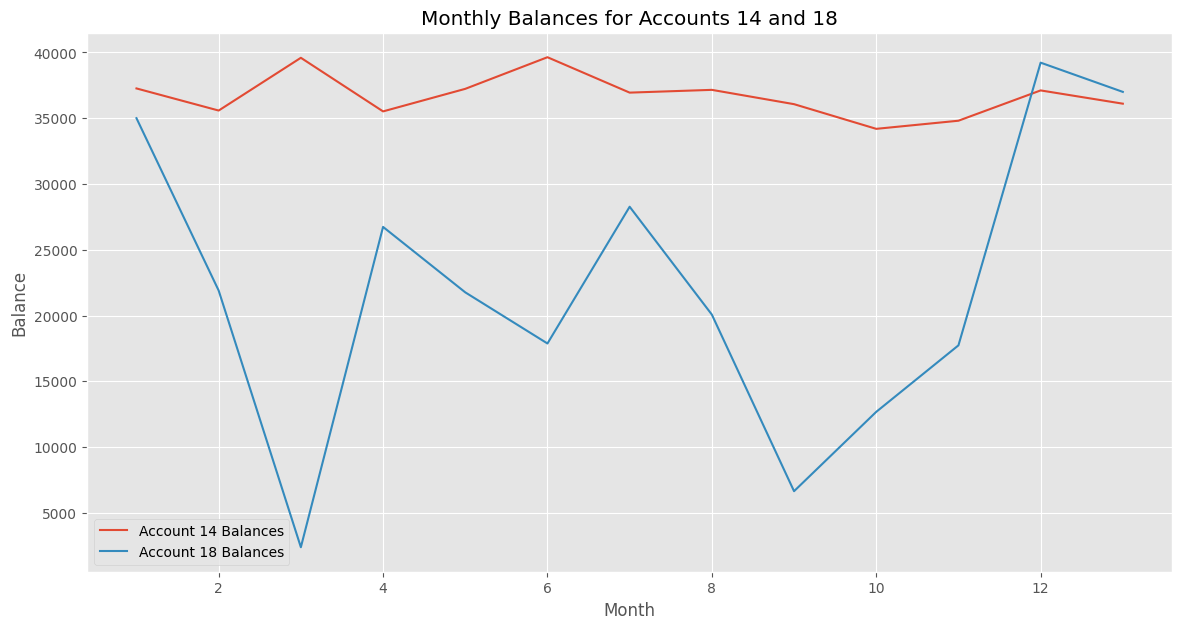

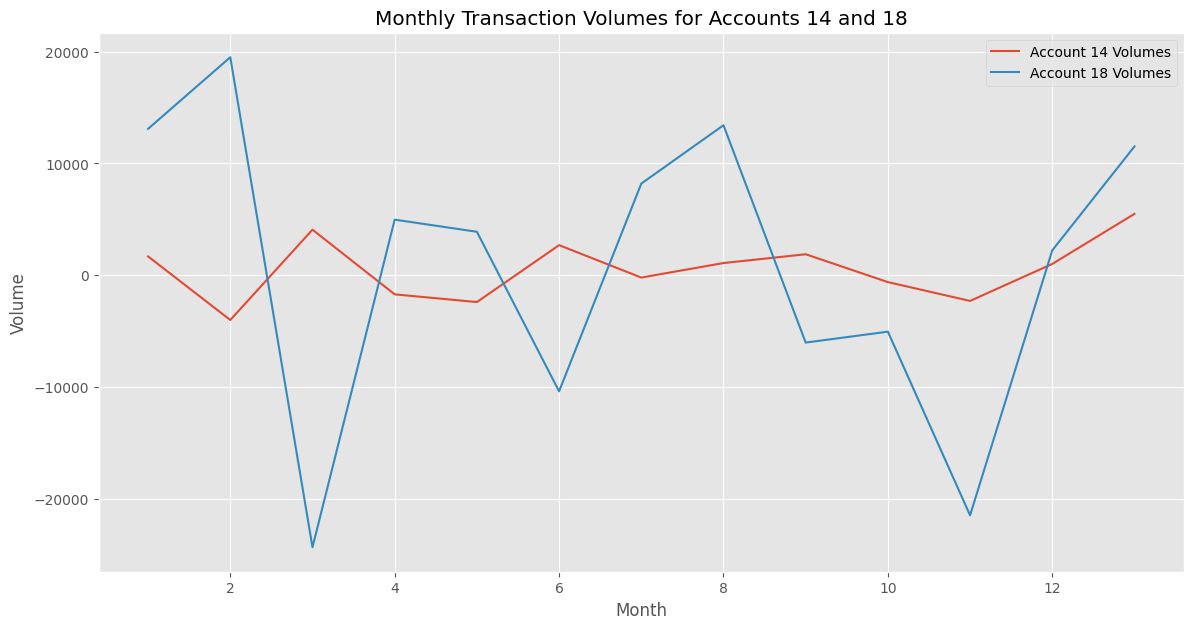

In [114]:
# Filter the data for accounts 14 and 18
account_data = X[X["account_id"].isin([14, 18])]
# Reshape the DataFrame for easier plotting
months = [f"Month {i}" for i in range(1, 14)]
balances = [f"balance_{i}" for i in range(1, 14)]
volumes = [f"volume_{i}" for i in range(1, 14)]

# Melt the DataFrame for balances and volumes
balance_data = account_data.melt(
    id_vars="account_id", value_vars=balances, var_name="Month", value_name="Balance"
)
volume_data = account_data.melt(
    id_vars="account_id", value_vars=volumes, var_name="Month", value_name="Volume"
)

# Convert 'Month' from string to integer for proper sorting
balance_data["Month"] = balance_data["Month"].str.extract(r"(\d+)").astype(int)
volume_data["Month"] = volume_data["Month"].str.extract(r"(\d+)").astype(int)

# Sort data by account and month
balance_data = balance_data.sort_values(by=["account_id", "Month"])
volume_data = volume_data.sort_values(by=["account_id", "Month"])
# Plotting balance data
plt.figure(figsize=(14, 7))
for key, grp in balance_data.groupby("account_id"):
    plt.plot(grp["Month"], grp["Balance"], label=f"Account {key} Balances")
plt.title("Monthly Balances for Accounts 14 and 18")
plt.xlabel("Month")
plt.ylabel("Balance")
plt.legend()
plt.show()

# Plotting volume data
plt.figure(figsize=(14, 7))
for key, grp in volume_data.groupby("account_id"):
    plt.plot(grp["Month"], grp["Volume"], label=f"Account {key} Volumes")
plt.title("Monthly Transaction Volumes for Accounts 14 and 18")
plt.xlabel("Month")
plt.ylabel("Volume")
plt.legend()
plt.show()

## Feature Engineering

In [115]:
# Function to calculate features
def calculate_features(df, prefix):
    monthly_values = df[[f"{prefix}_{i}" for i in range(1, 13)]]
    # needs to be a small constant to avoid division by zero
    epsilon = 1e-7  # small constant
    features = {
        f"{prefix}_mean": monthly_values.mean(axis=1),
        f"{prefix}_min": monthly_values.min(axis=1),
        f"{prefix}_max": monthly_values.max(axis=1),
        f"{prefix}_mad": monthly_values.sub(monthly_values.mean(axis=1), axis=0)
        .abs()
        .mean(axis=1),
        f"{prefix}_mean_ratio_last3_first3": (
            monthly_values[[f"{prefix}_{i}" for i in range(10, 13)]].mean(axis=1)
            / (
                monthly_values[[f"{prefix}_{i}" for i in range(1, 4)]].mean(axis=1)
                + epsilon
            )
        ),
    }

    if prefix in ["credit", "withdrawal"]:
        features[f"{prefix}_sum"] = monthly_values.sum(axis=1)
    if prefix in ["balance", "credit"]:
        features[f"{prefix}_std"] = monthly_values.std(axis=1)

    return features


# List of column prefixes for required calculations
columns_to_process = ["balance", "credit", "n_transactions", "withdrawal"]

# Generating features for each prefix and merging them
all_features = {}
for prefix in columns_to_process:
    all_features.update(calculate_features(X, prefix))

# Creating the final dataframe with new features
df_features = pd.DataFrame(all_features)


X_feature_engineered = pd.concat([X_res, df_features], axis=1)
display(X_feature_engineered.head(5))

,account_id,date_account,district_id_client,age,amount,duration,payments,household,insurance_payment,leasing,loan_payment,unknown,num_of_habitat_account,num_of_small_town_account,num_of_medium_town_account,num_of_big_town_account,num_of_bigger_town_account,num_of_city_account,ratio_of_urban_account,average_salary_account,unemploy_rate95_account,unemploy_rate96_account,n_of_enterpren_per1000_inhabit_account,no_of_crimes95_account,no_of_crimes96_account,num_of_habitat_client,num_of_small_town_client,num_of_medium_town_client,num_of_big_town_client,num_of_bigger_town_client,num_of_city_client,ratio_of_urban_client,average_salary_client,unemploy_rate95_client,unemploy_rate96_client,n_of_enterpren_per1000_inhabit_client,no_of_crimes95_client,no_of_crimes96_client,balance_1,balance_2,balance_3,balance_4,balance_5,balance_6,balance_7,balance_8,balance_9,balance_10,balance_11,balance_12,balance_13,credit_1,credit_2,credit_3,credit_4,credit_5,credit_6,credit_7,credit_8,credit_9,credit_10,credit_11,credit_12,credit_13,n_transactions_1,n_transactions_2,n_transactions_3,n_transactions_4,n_transactions_5,n_transactions_6,n_transactions_7,n_transactions_8,n_transactions_9,n_transactions_10,n_transactions_11,n_transactions_12,n_transactions_13,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,volume_8,volume_9,volume_10,volume_11,volume_12,volume_13,withdrawal_1,withdrawal_2,withdrawal_3,withdrawal_4,withdrawal_5,withdrawal_6,withdrawal_7,withdrawal_8,withdrawal_9,withdrawal_10,withdrawal_11,withdrawal_12,withdrawal_13,frequency_transactional,frequency_weekly,gender_male,status_contract finished,"status_finished contract, loan not paid",status_running contract,status_none,district_name_account_Beroun,district_name_account_Blansko,district_name_account_Breclav,district_name_account_Brno - mesto,district_name_account_Brno - venkov,district_name_account_Bruntal,district_name_account_Ceska Lipa,district_name_account_Ceske Budejovice,district_name_account_Cesky Krumlov,district_name_account_Cheb,district_name_account_Chomutov,district_name_account_Chrudim,district_name_account_Decin,district_name_account_Domazlice,district_name_account_Frydek - Mistek,district_name_account_Havlickuv Brod,district_name_account_Hl.m. Praha,district_name_account_Hodonin,district_name_account_Hradec Kralove,district_name_account_Jablonec n. Nisou,district_name_account_Jesenik,district_name_account_Jicin,district_name_account_Jihlava,district_name_account_Jindrichuv Hradec,district_name_account_Karlovy Vary,district_name_account_Karvina,district_name_account_Kladno,district_name_account_Klatovy,district_name_account_Kolin,district_name_account_Kromeriz,district_name_account_Kutna Hora,district_name_account_Liberec,district_name_account_Litomerice,district_name_account_Louny,district_name_account_Melnik,district_name_account_Mlada Boleslav,district_name_account_Most,district_name_account_Nachod,district_name_account_Novy Jicin,district_name_account_Nymburk,district_name_account_Olomouc,district_name_account_Opava,district_name_account_Ostrava - mesto,district_name_account_Pardubice,district_name_account_Pelhrimov,district_name_account_Pisek,district_name_account_Plzen - jih,district_name_account_Plzen - mesto,district_name_account_Plzen - sever,district_name_account_Prachatice,district_name_account_Praha - vychod,district_name_account_Praha - zapad,district_name_account_Prerov,district_name_account_Pribram,district_name_account_Prostejov,district_name_account_Rakovnik,district_name_account_Rokycany,district_name_account_Rychnov nad Kneznou,district_name_account_Semily,district_name_account_Sokolov,district_name_account_Strakonice,district_name_account_Sumperk,district_name_account_Svitavy,district_name_account_Tabor,district_name_account_Tachov,district_name_account_Teplice,district_name_account_Trebic,district_name_account_Trutnov,district_name_account_Uherske Hradiste,district_name_account_Usti nad Labem,district_name_account_Usti nad Orlici,district_nam

In [116]:
# Remove the Variable that can lead to data leakage
def clean_data(df):
    # Define unnecessary columns
    unnecessary_cols = [
        "disp_id",
        "client_id",
        "account_id",
        "type_card",
        "card_id",
        "loan_id",
        "district_id_account",
        "district_id_client",
    ]
    # Drop these columns if they exist in the dataframe
    df_cleaned = df.drop(columns=[col for col in unnecessary_cols if col in df.columns])
    return df_cleaned


X_res = clean_data(X_res)
X_feature_engineered = clean_data(X_feature_engineered)

In [117]:
display(X_feature_engineered.head(5))
display(X_res.head(5))

,date_account,age,amount,duration,payments,household,insurance_payment,leasing,loan_payment,unknown,num_of_habitat_account,num_of_small_town_account,num_of_medium_town_account,num_of_big_town_account,num_of_bigger_town_account,num_of_city_account,ratio_of_urban_account,average_salary_account,unemploy_rate95_account,unemploy_rate96_account,n_of_enterpren_per1000_inhabit_account,no_of_crimes95_account,no_of_crimes96_account,num_of_habitat_client,num_of_small_town_client,num_of_medium_town_client,num_of_big_town_client,num_of_bigger_town_client,num_of_city_client,ratio_of_urban_client,average_salary_client,unemploy_rate95_client,unemploy_rate96_client,n_of_enterpren_per1000_inhabit_client,no_of_crimes95_client,no_of_crimes96_client,balance_1,balance_2,balance_3,balance_4,balance_5,balance_6,balance_7,balance_8,balance_9,balance_10,balance_11,balance_12,balance_13,credit_1,credit_2,credit_3,credit_4,credit_5,credit_6,credit_7,credit_8,credit_9,credit_10,credit_11,credit_12,credit_13,n_transactions_1,n_transactions_2,n_transactions_3,n_transactions_4,n_transactions_5,n_transactions_6,n_transactions_7,n_transactions_8,n_transactions_9,n_transactions_10,n_transactions_11,n_transactions_12,n_transactions_13,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,volume_8,volume_9,volume_10,volume_11,volume_12,volume_13,withdrawal_1,withdrawal_2,withdrawal_3,withdrawal_4,withdrawal_5,withdrawal_6,withdrawal_7,withdrawal_8,withdrawal_9,withdrawal_10,withdrawal_11,withdrawal_12,withdrawal_13,frequency_transactional,frequency_weekly,gender_male,status_contract finished,"status_finished contract, loan not paid",status_running contract,status_none,district_name_account_Beroun,district_name_account_Blansko,district_name_account_Breclav,district_name_account_Brno - mesto,district_name_account_Brno - venkov,district_name_account_Bruntal,district_name_account_Ceska Lipa,district_name_account_Ceske Budejovice,district_name_account_Cesky Krumlov,district_name_account_Cheb,district_name_account_Chomutov,district_name_account_Chrudim,district_name_account_Decin,district_name_account_Domazlice,district_name_account_Frydek - Mistek,district_name_account_Havlickuv Brod,district_name_account_Hl.m. Praha,district_name_account_Hodonin,district_name_account_Hradec Kralove,district_name_account_Jablonec n. Nisou,district_name_account_Jesenik,district_name_account_Jicin,district_name_account_Jihlava,district_name_account_Jindrichuv Hradec,district_name_account_Karlovy Vary,district_name_account_Karvina,district_name_account_Kladno,district_name_account_Klatovy,district_name_account_Kolin,district_name_account_Kromeriz,district_name_account_Kutna Hora,district_name_account_Liberec,district_name_account_Litomerice,district_name_account_Louny,district_name_account_Melnik,district_name_account_Mlada Boleslav,district_name_account_Most,district_name_account_Nachod,district_name_account_Novy Jicin,district_name_account_Nymburk,district_name_account_Olomouc,district_name_account_Opava,district_name_account_Ostrava - mesto,district_name_account_Pardubice,district_name_account_Pelhrimov,district_name_account_Pisek,district_name_account_Plzen - jih,district_name_account_Plzen - mesto,district_name_account_Plzen - sever,district_name_account_Prachatice,district_name_account_Praha - vychod,district_name_account_Praha - zapad,district_name_account_Prerov,district_name_account_Pribram,district_name_account_Prostejov,district_name_account_Rakovnik,district_name_account_Rokycany,district_name_account_Rychnov nad Kneznou,district_name_account_Semily,district_name_account_Sokolov,district_name_account_Strakonice,district_name_account_Sumperk,district_name_account_Svitavy,district_name_account_Tabor,district_name_account_Tachov,district_name_account_Teplice,district_name_account_Trebic,district_name_account_Trutnov,district_name_account_Uherske Hradiste,district_name_account_Usti nad Labem,district_name_account_Usti nad Orlici,district_name_account_Vsetin,district_name

,date_account,age,amount,duration,payments,household,insurance_payment,leasing,loan_payment,unknown,num_of_habitat_account,num_of_small_town_account,num_of_medium_town_account,num_of_big_town_account,num_of_bigger_town_account,num_of_city_account,ratio_of_urban_account,average_salary_account,unemploy_rate95_account,unemploy_rate96_account,n_of_enterpren_per1000_inhabit_account,no_of_crimes95_account,no_of_crimes96_account,num_of_habitat_client,num_of_small_town_client,num_of_medium_town_client,num_of_big_town_client,num_of_bigger_town_client,num_of_city_client,ratio_of_urban_client,average_salary_client,unemploy_rate95_client,unemploy_rate96_client,n_of_enterpren_per1000_inhabit_client,no_of_crimes95_client,no_of_crimes96_client,balance_1,balance_2,balance_3,balance_4,balance_5,balance_6,balance_7,balance_8,balance_9,balance_10,balance_11,balance_12,balance_13,credit_1,credit_2,credit_3,credit_4,credit_5,credit_6,credit_7,credit_8,credit_9,credit_10,credit_11,credit_12,credit_13,n_transactions_1,n_transactions_2,n_transactions_3,n_transactions_4,n_transactions_5,n_transactions_6,n_transactions_7,n_transactions_8,n_transactions_9,n_transactions_10,n_transactions_11,n_transactions_12,n_transactions_13,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,volume_8,volume_9,volume_10,volume_11,volume_12,volume_13,withdrawal_1,withdrawal_2,withdrawal_3,withdrawal_4,withdrawal_5,withdrawal_6,withdrawal_7,withdrawal_8,withdrawal_9,withdrawal_10,withdrawal_11,withdrawal_12,withdrawal_13,frequency_transactional,frequency_weekly,gender_male,status_contract finished,"status_finished contract, loan not paid",status_running contract,status_none,district_name_account_Beroun,district_name_account_Blansko,district_name_account_Breclav,district_name_account_Brno - mesto,district_name_account_Brno - venkov,district_name_account_Bruntal,district_name_account_Ceska Lipa,district_name_account_Ceske Budejovice,district_name_account_Cesky Krumlov,district_name_account_Cheb,district_name_account_Chomutov,district_name_account_Chrudim,district_name_account_Decin,district_name_account_Domazlice,district_name_account_Frydek - Mistek,district_name_account_Havlickuv Brod,district_name_account_Hl.m. Praha,district_name_account_Hodonin,district_name_account_Hradec Kralove,district_name_account_Jablonec n. Nisou,district_name_account_Jesenik,district_name_account_Jicin,district_name_account_Jihlava,district_name_account_Jindrichuv Hradec,district_name_account_Karlovy Vary,district_name_account_Karvina,district_name_account_Kladno,district_name_account_Klatovy,district_name_account_Kolin,district_name_account_Kromeriz,district_name_account_Kutna Hora,district_name_account_Liberec,district_name_account_Litomerice,district_name_account_Louny,district_name_account_Melnik,district_name_account_Mlada Boleslav,district_name_account_Most,district_name_account_Nachod,district_name_account_Novy Jicin,district_name_account_Nymburk,district_name_account_Olomouc,district_name_account_Opava,district_name_account_Ostrava - mesto,district_name_account_Pardubice,district_name_account_Pelhrimov,district_name_account_Pisek,district_name_account_Plzen - jih,district_name_account_Plzen - mesto,district_name_account_Plzen - sever,district_name_account_Prachatice,district_name_account_Praha - vychod,district_name_account_Praha - zapad,district_name_account_Prerov,district_name_account_Pribram,district_name_account_Prostejov,district_name_account_Rakovnik,district_name_account_Rokycany,district_name_account_Rychnov nad Kneznou,district_name_account_Semily,district_name_account_Sokolov,district_name_account_Strakonice,district_name_account_Sumperk,district_name_account_Svitavy,district_name_account_Tabor,district_name_account_Tachov,district_name_account_Teplice,district_name_account_Trebic,district_name_account_Trutnov,district_name_account_Uherske Hradiste,district_name_account_Usti nad Labem,district_name_account_Usti nad Orlici,district_name_account_Vsetin,district_name

In [118]:
# only print the columns with missing values
X_res.isnull().sum()[X_res.isnull().sum() > 0]
X_feature_engineered.isnull().sum()[X_feature_engineered.isnull().sum() > 0]

balance_mean                              996
balance_min                               996
balance_max                               996
balance_mad                               996
balance_mean_ratio_last3_first3           996
balance_std                               996
credit_mean                               996
credit_min                                996
credit_max                                996
credit_mad                                996
credit_mean_ratio_last3_first3            996
credit_sum                                996
credit_std                                996
n_transactions_mean                       996
n_transactions_min                        996
n_transactions_max                        996
n_transactions_mad                        996
n_transactions_mean_ratio_last3_first3    996
withdrawal_mean                           996
withdrawal_min                            996
withdrawal_max                            996
withdrawal_mad                    

In [119]:
# impute missing values with knn imputation but in dataframe
# import KNNImputer
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
X_res = pd.DataFrame(imputer.fit_transform(X_res), columns=X_res.columns)
X_feature_engineered = pd.DataFrame(
    imputer.fit_transform(X_feature_engineered), columns=X_feature_engineered.columns
)

In [120]:
# only print the columns with missing values
X_res.isnull().sum()[X_res.isnull().sum() > 0]
X_feature_engineered.isnull().sum()[X_feature_engineered.isnull().sum() > 0]

Series([], dtype: int64)

In [121]:
# Nomalize the data and standardize the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_res = pd.DataFrame(scaler.fit_transform(X_res), columns=X_res.columns)
X_feature_engineered = pd.DataFrame(
    scaler.fit_transform(X_feature_engineered), columns=X_feature_engineered.columns
)

# Evaluations Daten

In [122]:
# Assuming 'X' is your DataFrame and 'has_card' is the target variable
# y_features = X_feature_engineered["has_card"]

# X_feature_engineered.drop("has_card", axis=1, inplace=True)
# we use kfold for cross validation and then the X_test and y_test are used for evaluation on never seen data
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.1, random_state=42, stratify=y_res
)

X_train_features, X_test_features, y_train_features, y_test_features = train_test_split(
    X_feature_engineered, y_res, test_size=0.1, random_state=42, stratify=y_res
)

## Drop Featrues

In [123]:
X_train.dtypes

date_account                                 float64
age                                          float64
amount                                       float64
duration                                     float64
payments                                     float64
household                                    float64
insurance_payment                            float64
leasing                                      float64
loan_payment                                 float64
unknown                                      float64
num_of_habitat_account                       float64
num_of_small_town_account                    float64
num_of_medium_town_account                   float64
num_of_big_town_account                      float64
num_of_bigger_town_account                   float64
num_of_city_account                          float64
ratio_of_urban_account                       float64
average_salary_account                       float64
unemploy_rate95_account                      f

# Modeling und Model Selection
Für die Model Selection benutzen wir einen StratifiedKFold mit 10 Folds in dem wir nur den Train split Folden, denn später brauchen wir die Test Daten für den Error Assesment.

In [124]:
from lime.lime_tabular import LimeTabularExplainer
import os
import joblib


# Define the directory to save models
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)


class ModelEvaluator:
    def __init__(self, models, param_grid, X, y, X_test, y_test, selected_fields=None):
        """
        Initialize the evaluator with models, their parameter grids, and data.

        :param models: dict of (name, model) pairs
        :param param_grid: dict of (name, param_grid) pairs for GridSearch
        :param X: Feature matrix
        :param y: Target vector
        :param selected_fields: Fields selected for training
        """
        self.benchmark_results = {}
        self.models = models
        self.param_grid = param_grid
        self.X = X[selected_fields]
        self.y = y
        self.eval_data = X_test
        self.eval_target = y_test
        self.fitted_models = {}
        self.best_models = {}
        self.cv_predictions = {}

        self.load_all_models()

    def save_model(self, model, model_name):
        joblib.dump(model, os.path.join(MODEL_DIR, f"{model_name}.pkl"))
        # Save CV predictions if they exist
        if model_name in self.cv_predictions:
            joblib.dump(self.cv_predictions[model_name], os.path.join(MODEL_DIR, f"{model_name}_cv_preds.pkl"))

    def load_model(self, model_name):
        model_path = os.path.join(MODEL_DIR, f"{model_name}.pkl")
        cv_preds_path = os.path.join(MODEL_DIR, f"{model_name}_cv_preds.pkl")
        if os.path.exists(model_path):
            model = joblib.load(model_path)
            if os.path.exists(cv_preds_path):
                cv_preds = joblib.load(cv_preds_path)
                self.cv_predictions[model_name] = cv_preds
            return model
        else:
            return None

    def load_all_models(self):
        for name in self.models:
            model = self.load_model(name)
            if model:
                print(f"Loaded saved model for {name}")
                self.fitted_models[name] = model

    def get_benchmark_results(self):
        return self.benchmark_results

    def fit_models(self):
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        for name, model in self.models.items():
            if name in self.fitted_models:
                print(f"Skipping training for {name} as it is already loaded")
                continue

            pipeline = self.create_pipeline(model)

            # Prefix the parameters with the step name 'model'
            grid_search_params = {f"model__{param}": values for param, values in self.param_grid[name].items()}

            grid_search = GridSearchCV(
                estimator=pipeline,
                param_grid=grid_search_params,
                cv=cv,
                scoring="accuracy",
                n_jobs=-1,
                verbose=1,
            )

            grid_search.fit(self.X, self.y)
            print(f"Best parameters for {name}: {grid_search.best_params_}")
            best_pipeline = grid_search.best_estimator_
            self.save_model(best_pipeline, name)
            print(f"Saved model for {name}")

            metrics = {
                "roc_auc": "roc_auc",
                "precision": "precision",
                "recall": "recall",
                "accuracy": "accuracy",
                "f1": make_scorer(fbeta_score, beta=1),
                "kappa": make_scorer(cohen_kappa_score),
                "mcc": make_scorer(matthews_corrcoef),
            }

            self.benchmark_results[name] = {}
            all_cv_preds = np.zeros(len(self.y))

            results = cross_validate(
                best_pipeline,
                self.X,
                self.y,
                cv=cv,
                scoring=metrics,
                return_estimator=True,
                n_jobs=-1,
                verbose=0,
            )

            for metric_name in metrics.keys():
                self.benchmark_results[name][metric_name] = np.mean(results["test_" + metric_name])
                print(f"{name}: {metric_name} = {np.mean(results['test_' + metric_name]):.2f}")

            for train_idx, test_idx in cv.split(self.X, self.y):
                best_pipeline.fit(self.X.iloc[train_idx], self.y.iloc[train_idx])
                all_cv_preds[test_idx] = best_pipeline.predict_proba(self.X.iloc[test_idx])[:, 1]

            self.cv_predictions[name] = all_cv_preds
            self.fitted_models[name] = best_pipeline.fit(self.X, self.y)

            # Save the CV predictions after fitting
            self.save_model(best_pipeline, name)

    def evaluate_models(self):
        if not self.fitted_models:
            self.fit_models()
        return self.benchmark_results

    def plot_roc_curves(self):
        if not self.fitted_models:
            self.fit_models()

        plt.figure(figsize=(10, 8))
        for name in self.fitted_models:
            if name not in self.cv_predictions:
                print(f"Warning: No CV predictions for {name}")
                continue

            y_scores = self.cv_predictions[name]
            fpr, tpr, _ = roc_curve(self.y, y_scores)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (area = {roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curves")
        plt.legend(loc="lower right")
        plt.show()

    def create_pipeline(self, model):
        categorical_cols = self.X.select_dtypes(include=["category", "object"]).columns
        numeric_cols = self.X.select_dtypes(include=["int64", "float64"]).columns

        numeric_transformer = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ])

        categorical_transformer = Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ])

        preprocessor = ColumnTransformer([
            ("num", numeric_transformer, numeric_cols),
            ("cat", categorical_transformer, categorical_cols),
        ])

        return Pipeline([("preprocessor", preprocessor), ("model", model)])

    def compare_top_n_customers(self, model_name, n=100):
        print(f"Comparing top {n} customers for {model_name}")
        model = self.fitted_models[model_name]
        probabilities = model.predict_proba(self.eval_data)[:, 1]
        predictions = model.predict(self.eval_data)
        top_n_indices = np.argsort(probabilities)[::-1][:n]

        plt.figure()
        plt.hist(probabilities[top_n_indices], bins=20, alpha=0.75)
        plt.title(f"Histogram of top {n} customers' probabilities for {model_name}")
        plt.xlabel("Probability")
        plt.ylabel("Frequency")
        plt.show()

        data = {'predictions': predictions, 'probabilities': probabilities}
        return pd.DataFrame(data)

    def plot_confusion_matrices(self):
        if not self.fitted_models:
            self.fit_models()

        for name, model in self.fitted_models.items():
            plt.style.use("default")
            y_pred = model.predict(self.X)
            cm = confusion_matrix(self.y, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(cmap=plt.cm.Blues)
            plt.title(f"Confusion Matrix for {name}")
            plt.show()
            plt.style.use("ggplot")


class MetricsBenchmarker:
    def __init__(self):
        """
        Initialize the benchmarker with models and data.

        :param models: dict of (name, model) pairs
        :param X: Feature matrix
        :param y: Target vector
        :param selected_fields: Fields selected for training
        """
        self.benchmark_results = {}
        self.evals = []

    def add_evaluator(self, evaluator: ModelEvaluator):
        self.evals.append(evaluator)

    def set_benchmark_results(self):
        for eval in self.evals:
            self.benchmark_results.update(eval.get_benchmark_results())

    def display_benchmark_results_table(self):
        """
        Display a table of benchmark results.
        """
        results_df = pd.DataFrame(self.benchmark_results).T
        display(results_df)

    def plot_benchmark_results_bar_chart(self):
        """
        Plot a bar chart of benchmark results.
        """
        results_df = pd.DataFrame(self.benchmark_results).T
        results_df.plot(kind="bar", figsize=(10, 6))
        plt.title("Benchmark Results")
        plt.ylabel("Score")
        plt.show()

Loaded saved model for Baseline Logistic Regression


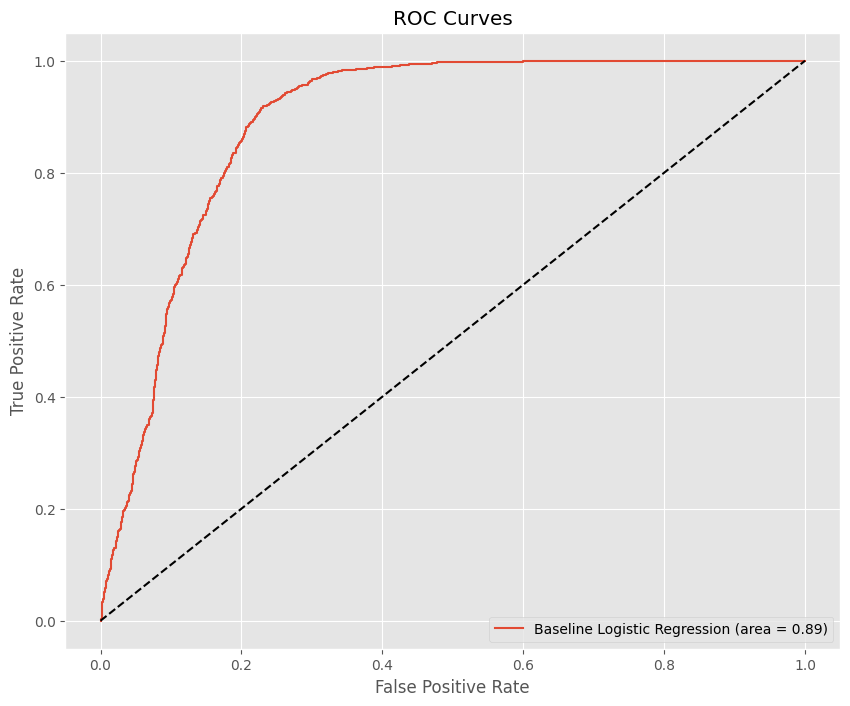

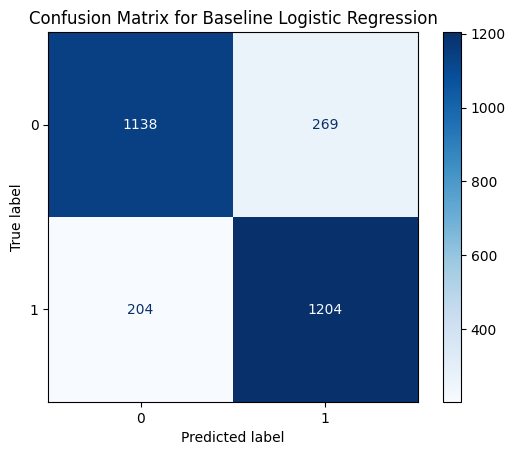

Comparing top 100 customers for Baseline Logistic Regression


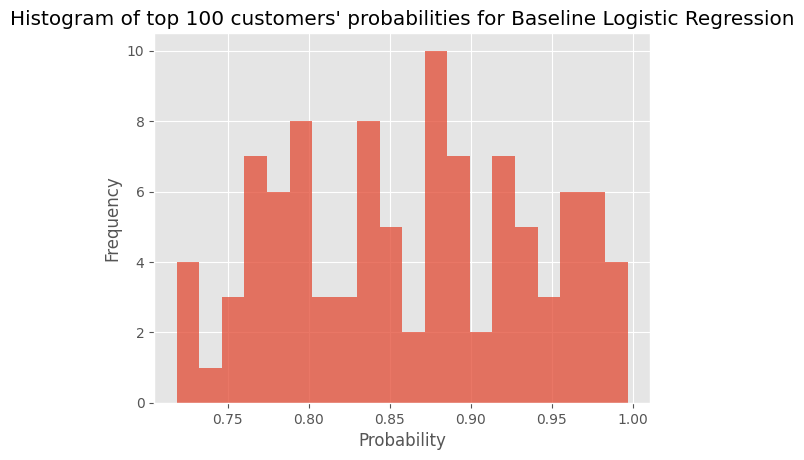

In [125]:
model_predictions = {}
# Example usage
from sklearn.linear_model import LogisticRegression

# Define models and their parameter grids
models = {
    "Baseline Logistic Regression": LogisticRegression(solver="liblinear"),
}
param_grid = {
    "Baseline Logistic Regression": {"C": [0.01, 0.1, 1, 10]},
}

selected_fields = (
    ["age"]
    + [col for col in X_train.columns if "gender" in col]
    + [col for col in X_train.columns if "region_client" in col]
    + [f"volume_{i}" for i in range(1, 14)]
    + [f"balance_{i}" for i in range(1, 14)]
)


evaluator_baseline = ModelEvaluator(
    models,
    param_grid,
    X_train,
    y_train,
    X_test,
    y_test,
    selected_fields=selected_fields,
)
evaluator_baseline.evaluate_models()
evaluator_baseline.plot_roc_curves()
evaluator_baseline.plot_confusion_matrices()
predictions = evaluator_baseline.compare_top_n_customers(
    "Baseline Logistic Regression", n=100
)
predictions["account_id"] = X_test.index.values

model_predictions["Baseline Logistic Regression"] = predictions

Loaded saved model for Logistic Regression Features


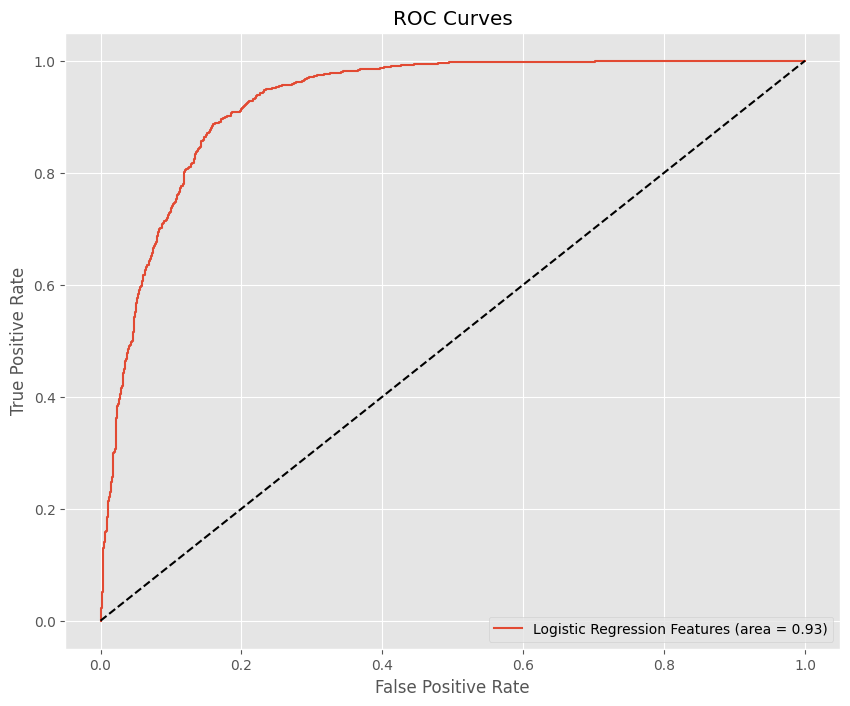

Comparing top 100 customers for Logistic Regression Features


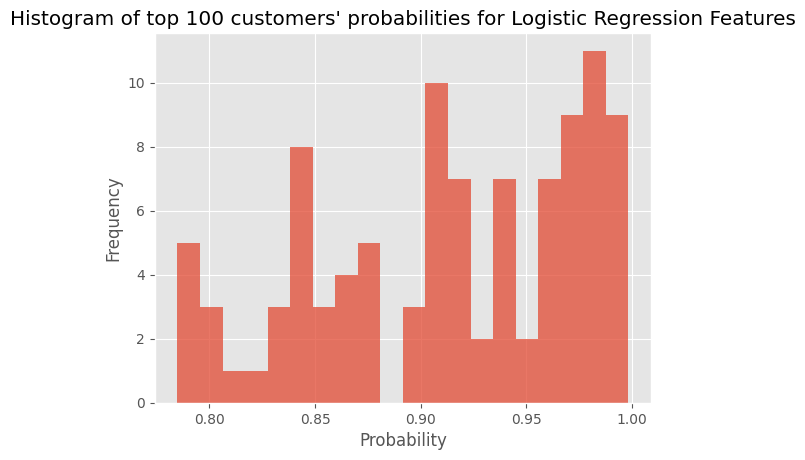

In [126]:
# Define models and their parameter grids
models = {
    "Logistic Regression Features": LogisticRegression(solver="liblinear"),
}
param_grid = {
    "Logistic Regression Features": {"C": [0.01, 0.1, 1, 10]},
}

selected_fields = X_train_features.columns

evaluator = ModelEvaluator(
    models,
    param_grid,
    X_train_features,
    y_train_features,
    X_test_features,
    y_test_features,
    selected_fields=selected_fields,
)
evaluator.evaluate_models()
evaluator.plot_roc_curves()
predictions = evaluator.compare_top_n_customers("Logistic Regression Features", n=100)
predictions["account_id"] = X_test.index.values
model_predictions["Logistic Regression Features"] = predictions

## Overfitting because of jagged ROC curve needs Regularization

Loaded saved model for Logistic Regression Features added


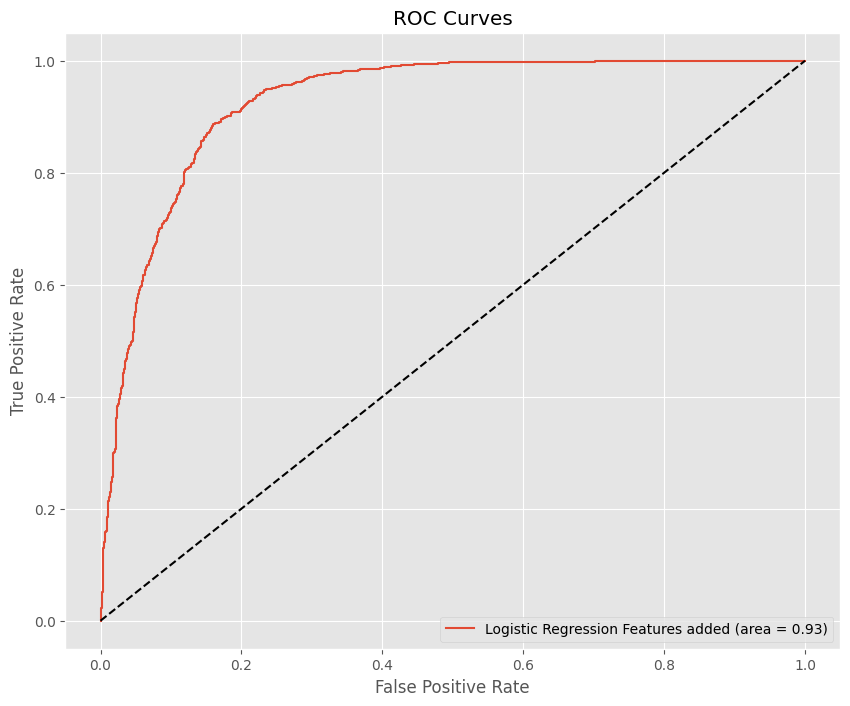

Comparing top 100 customers for Logistic Regression Features added


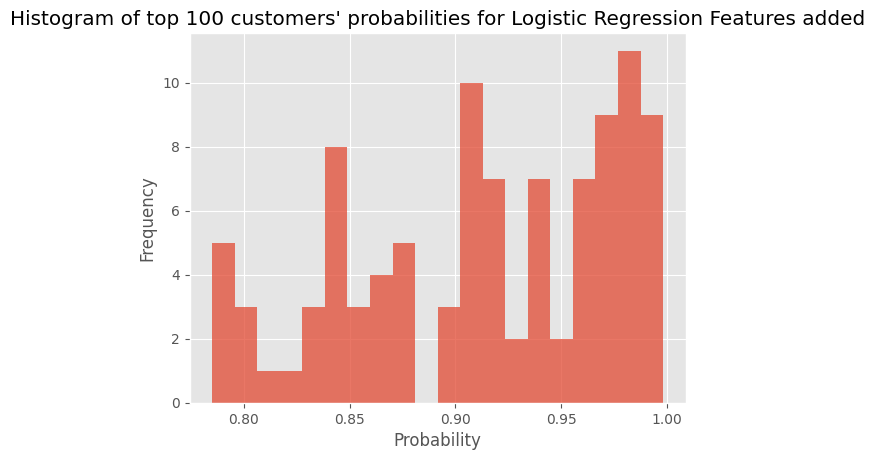

In [127]:
# Define models and their parameter grids
models = {
    "Logistic Regression Features added": LogisticRegression(solver="liblinear"),
}
param_grid = {
    "Logistic Regression Features added": {"C": [0.001, 0.01, 0.1, 1, 10]},
}

selected_fields = X_train_features.columns

# Fix the not converging models with LassoCV
# for model_name, model in models.items():
#    models[model_name] = Pipeline(
#        [
#            ("scaler", StandardScaler()),
#            (
#                "feature_selection",
#                SelectFromModel(LassoCV(alphas=[0.01, 0.1, 1, 10], max_iter=10000)),
#            ),
#            ("model", model),
#        ]
#    )


evaluator = ModelEvaluator(
    models,
    param_grid,
    X_train_features,
    y_train_features,
    X_test_features,
    y_test_features,
    selected_fields=selected_fields,
)


evaluator.evaluate_models()
evaluator.plot_roc_curves()
predictions = evaluator.compare_top_n_customers(
    "Logistic Regression Features added", n=100
)
predictions["account_id"] = X_test.index.values
model_predictions["Logistic Regression Features added"] = predictions

Loaded saved model for Random Forest
Loaded saved model for Gradient Boosting


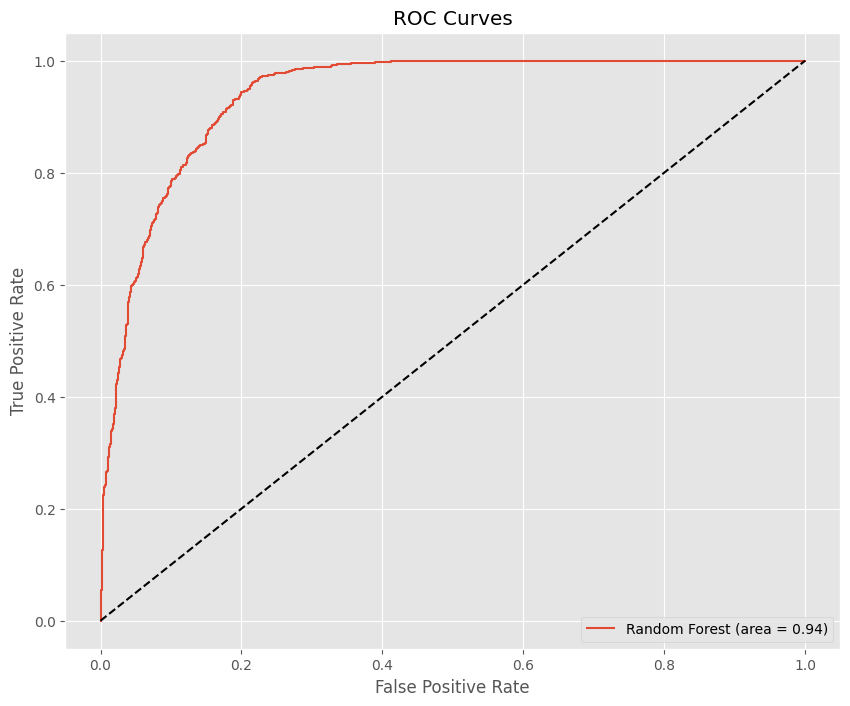

In [128]:
import joblib
import os


from sklearn.ensemble import BaggingClassifier, StackingClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Define base models for stacking
base_models = [
    ("rf", RandomForestClassifier(n_estimators=100)),
    ("gb", GradientBoostingClassifier(n_estimators=100)),
    ("svc", make_pipeline(StandardScaler(), SVC(probability=True))),
]

# Flag for debug mode
debug_mode = True


# Usage example:
# Define models and their parameter grids
models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "AdaBoost": AdaBoostClassifier(algorithm="SAMME"),
    "Bagging": BaggingClassifier(estimator=DecisionTreeClassifier()),
    "Stacking": StackingClassifier(
        estimators=base_models, final_estimator=LogisticRegression()
    ),
}

# Full parameter grid
param_grid_full = {
    "Random Forest": {
        "n_estimators": [100, 200, 300, 400],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.1, 0.01, 0.001],
        "max_depth": [3, 4, 5, 6],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "subsample": [0.8, 0.9, 1.0],
    },
    "SVM": {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear", "rbf", "poly"],
        "gamma": ["scale", "auto"],
        "degree": [3, 4, 5],
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        "leaf_size": [20, 30, 40],
    },
    "Decision Tree": {
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"],
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [1.0, 0.1, 0.01],
        "algorithm": ["SAMME", "SAMME.R"],
    },
    "Bagging": {
        "n_estimators": [10, 50, 100],
        "max_samples": [0.5, 0.7, 1.0],
        "max_features": [0.5, 0.7, 1.0],
        "bootstrap": [True, False],
        "bootstrap_features": [True, False],
    },
    "Stacking": {
        "final_estimator__C": [0.1, 1, 10, 100],
        "final_estimator__penalty": ["l2", "none"],
    },
}

# Debug parameter grid
param_grid_debug = {
    "Random Forest": {
        "n_estimators": [100],
        "max_depth": [5],
    },
    "Gradient Boosting": {
        "n_estimators": [100],
        "learning_rate": [0.1],
    },
    "SVM": {
        "C": [1],
        "kernel": ["linear"],
    },
    "KNN": {
        "n_neighbors": [3],
        "weights": ["uniform"],
    },
    "Decision Tree": {
        "max_depth": [5],
    },
    "AdaBoost": {
        "n_estimators": [50],
        "learning_rate": [1.0],
    },
    "Bagging": {
        "n_estimators": [10],
    },
    "Stacking": {
        "final_estimator__C": [1],
    },
}

# Select parameter grid based on debug mode
param_grid = param_grid_debug if debug_mode else param_grid_full

selected_fields = X_train_features.columns  # add the new features of df_features

evaluator_models = ModelEvaluator(
    models,
    param_grid,
    X_train_features,
    y_train_features,
    X_test_features,
    y_test_features,
    selected_fields=selected_fields,
)
results = evaluator_models.evaluate_models()
evaluator_models.plot_roc_curves()


## Vergleich der Top-N Kundenlisten

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def compare_top_customers(predictions, n):
    top_n = {}
    for model, pred_df in predictions.items():
        top_customers = pred_df.nlargest(n, "probabilities")["account_id"]
        top_n[model] = set(top_customers)

    model_names = list(predictions.keys())
    overlaps = pd.DataFrame(0.0, index=model_names, columns=model_names)

    for i in range(len(model_names)):
        for j in range(i, len(model_names)):
            model1, model2 = model_names[i], model_names[j]
            overlap = len(top_n[model1].intersection(top_n[model2])) / n
            overlaps.loc[model1, model2] = overlap
            overlaps.loc[model2, model1] = overlap

    plt.figure(figsize=(10, 10))
    sns.heatmap(overlaps, annot=True, cmap="viridis")
    plt.title("Overlap of Top Customers Between Models")
    plt.show()

    return overlaps

Comparing top 100 customers for Random Forest


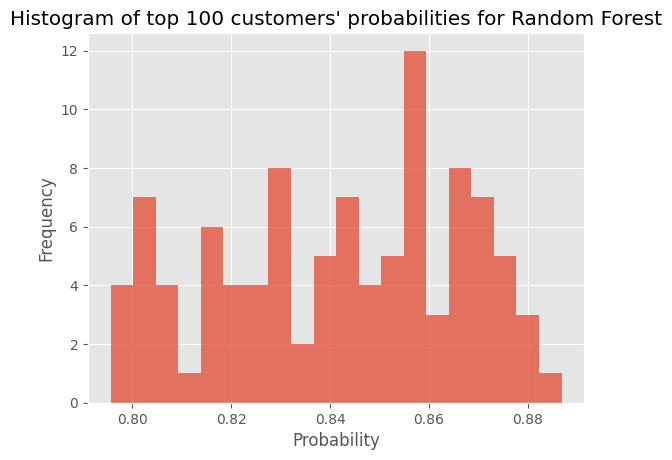

Comparing top 100 customers for Gradient Boosting


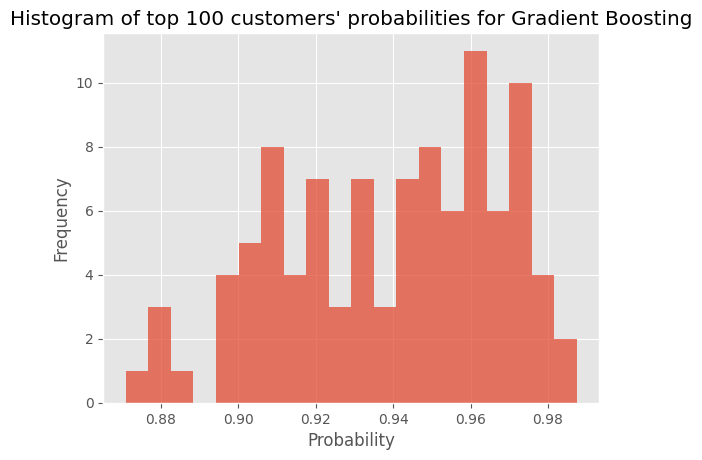

Comparing top 100 customers for SVM


KeyError: 'SVM'

In [130]:
# compare top n customers for all models
for model_name in models.keys():
    predictions = evaluator_models.compare_top_n_customers(model_name, n=100)
    predictions["account_id"] = X_test.index.values
    model_predictions[model_name] = predictions

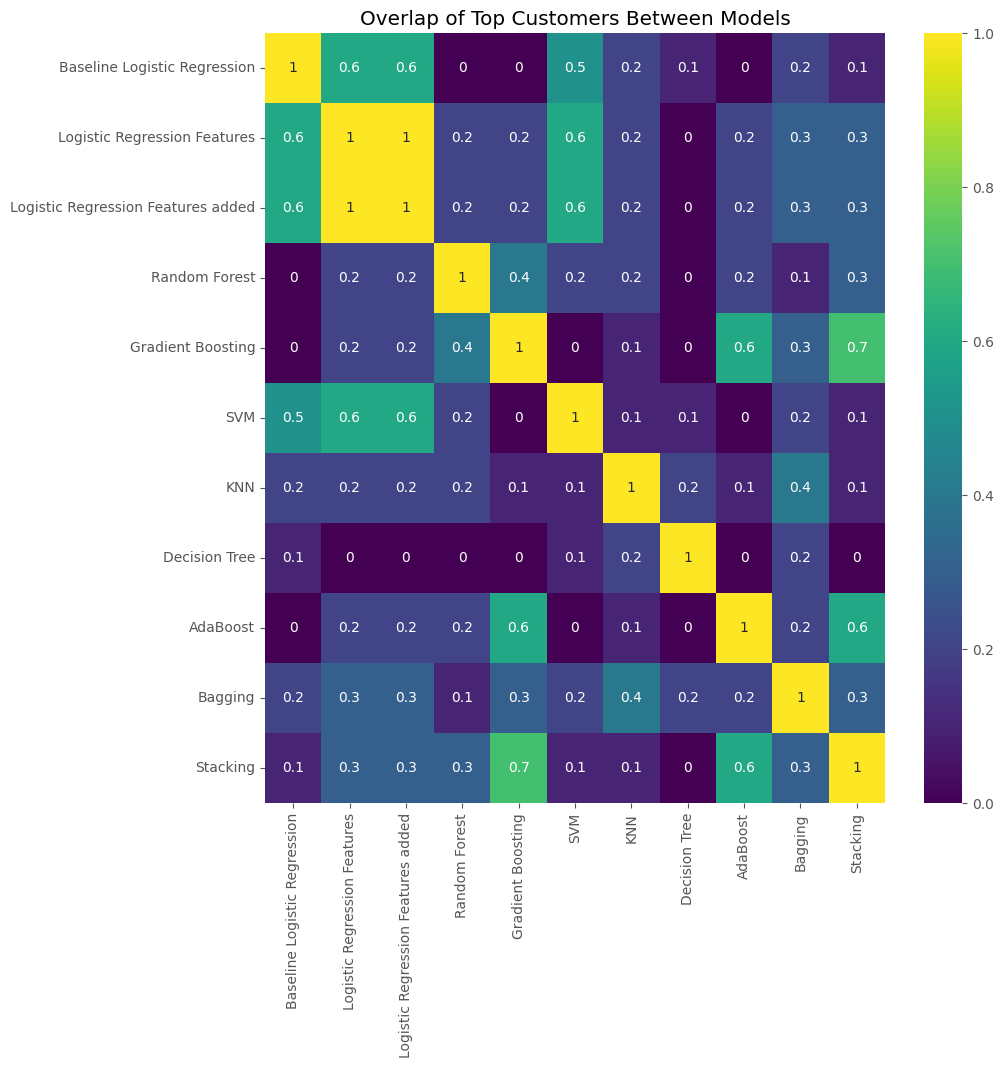

,Baseline Logistic Regression,Logistic Regression Features,Logistic Regression Features added,Random Forest,Gradient Boosting,SVM,KNN,Decision Tree,AdaBoost,Bagging,Stacking
Baseline Logistic Regression,1.0,0.6,0.6,0.0,0.0,0.5,0.2,0.1,0.0,0.2,0.1
Logistic Regression Features,0.6,1.0,1.0,0.2,0.2,0.6,0.2,0.0,0.2,0.3,0.3
Logistic Regression Features added,0.6,1.0,1.0,0.2,0.2,0.6,0.2,0.0,0.2,0.3,0.3
Random Forest,0.0,0.2,0.2,1.0,0.4,0.2,0.2,0.0,0.2,0.1,0.3
Gradient Boosting,0.0,0.2,0.2,0.4,1.0,0.0,0.1,0.0,0.6,0.3,0.7
SVM,0.5,0.6,0.6,0.2,0.0,1.0,0.1,0.1,0.0,0.2,0.1
KNN,0.2,0.2,0.2,0.2,0.1,0.1,1.0,0.2,0.1,0.4,0.1
Decision Tree,0.1,0.0,0.0,0.0,0.0,0.1,0.2,1.0,0.0,0.2,0.0
AdaBoost,0.0,0.2,0.2,0.2,0.6,0.0,0.1,0.0,1.0,0.2,0.6
Bagging,0.2,0.3,0.3,0.1,0.3,0.2,0.4,0.2,0.2,1.0,0.3


In [ ]:
compare_top_customers(model_predictions, 10)

Die oben gezeigte Matrix zeigt die Überlappung von der top 10 account_ids, welche von dem jeweiligen Modell als potentieller Kreditkartenkäufer identifiziert wurde.
Einzig die logistischen regressions Modelle zeigen eine Überlappung von mehr als 50%. Ansonsten weisen die Resultate vom AdaBoost und dem Gradient Boosting Modell eine Überlappung von 50% auf. Alle anderen Modellkombinationen überschneiden sich in der Top-N Liste kaum.

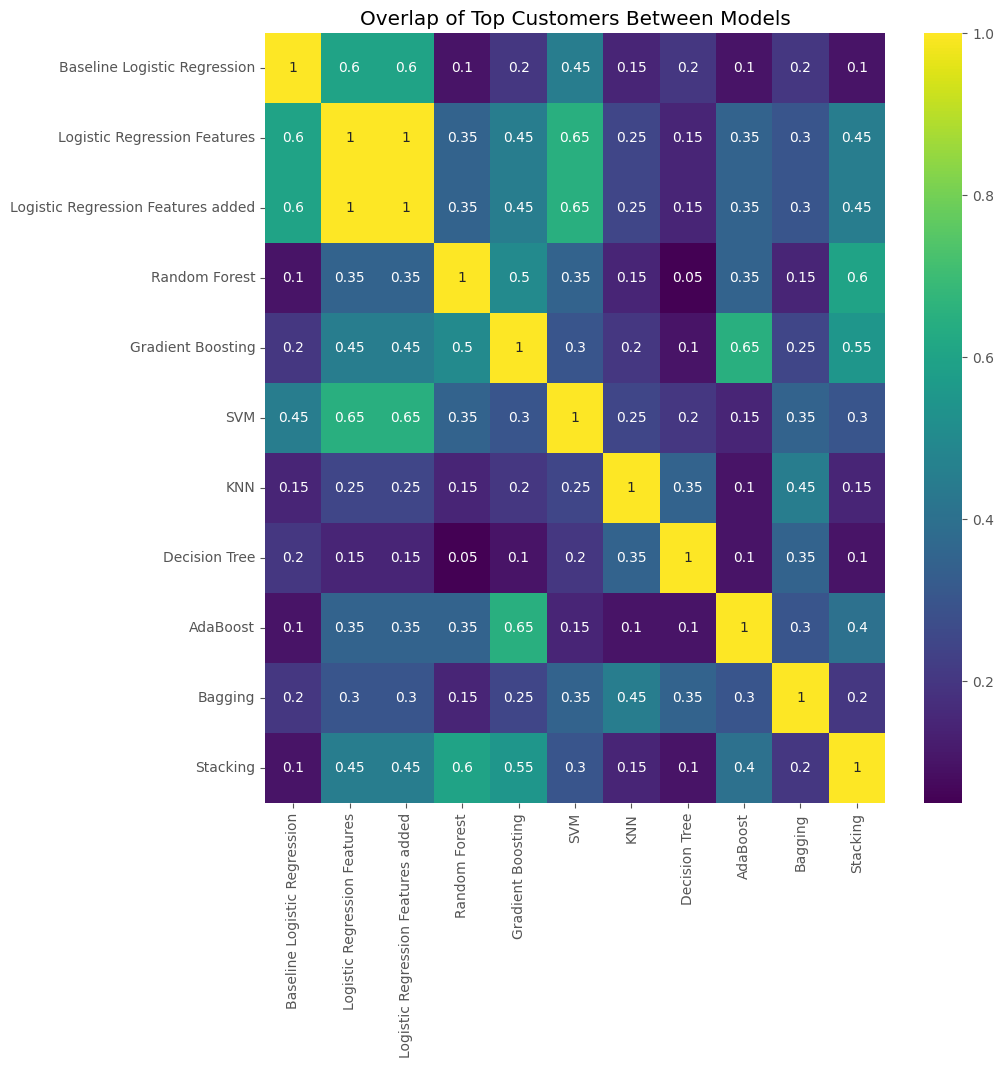

,Baseline Logistic Regression,Logistic Regression Features,Logistic Regression Features added,Random Forest,Gradient Boosting,SVM,KNN,Decision Tree,AdaBoost,Bagging,Stacking
Baseline Logistic Regression,1.00,0.60,0.60,0.10,0.20,0.45,0.15,0.20,0.10,0.20,0.10
Logistic Regression Features,0.60,1.00,1.00,0.35,0.45,0.65,0.25,0.15,0.35,0.30,0.45
Logistic Regression Features added,0.60,1.00,1.00,0.35,0.45,0.65,0.25,0.15,0.35,0.30,0.45
Random Forest,0.10,0.35,0.35,1.00,0.50,0.35,0.15,0.05,0.35,0.15,0.60
Gradient Boosting,0.20,0.45,0.45,0.50,1.00,0.30,0.20,0.10,0.65,0.25,0.55
SVM,0.45,0.65,0.65,0.35,0.30,1.00,0.25,0.20,0.15,0.35,0.30
KNN,0.15,0.25,0.25,0.15,0.20,0.25,1.00,0.35,0.10,0.45,0.15
Decision Tree,0.20,0.15,0.15,0.05,0.10,0.20,0.35,1.00,0.10,0.35,0.10
AdaBoost,0.10,0.35,0.35,0.35,0.65,0.15,0.10,0.10,1.00,0.30,0.40
Bagging,0.20,0.30,0.30,0.15,0.25,0.35,0.45,0.35,0.30,1.00,0.20


In [ ]:
compare_top_customers(model_predictions, 20)

Die oben gezeigte Matrix zeigt die Überlappung von der top 20 account_ids, welche von dem jeweiligen Modell als potentieller Kreditkartenkäufer identifiziert wurde.
Auch hier zeigen die logistischen regressions Modelle eine Überlappung von mehr als 50%. Das Gradient Boosting Modell weist nun aber eine 55%-ige Übereinstimmung mit dem Random Forest Modell und die Resultate vom AdaBoost Modell weist eine Übereinstimmung von 65% mit den Resultaten vom Gradient Boosting Modell.  Insgesamt erhöht sich die Überlappung der Listen im Vergleich zu den Top-10 Listen.

## Results Comparision

In [ ]:
benchmark = MetricsBenchmarker()
benchmark.add_evaluator(evaluator_baseline)
benchmark.add_evaluator(evaluator_models)
benchmark.add_evaluator(evaluator)
benchmark.set_benchmark_results()
benchmark.display_benchmark_results_table()
benchmark.plot_benchmark_results_bar_chart()

""


TypeError: no numeric data to plot

In [ ]:
# best model
# Define weights for the metrics
weights = {"roc_auc": 0.25, "precision": 0.25, "recall": 0.25, "f1": 0.25}

# Calculate weighted scores for each model
weighted_scores = {}
for model, metrics in benchmark.benchmark_results.items():
    weighted_score = sum(
        weights[metric] * score
        for metric, score in metrics.items()
        if metric in weights
    )
    weighted_scores[model] = weighted_score

# Find the best model based on weighted score
best_model_name = max(weighted_scores, key=weighted_scores.get)
best_model_score = weighted_scores[best_model_name]

# Model Assesment

In [ ]:
# plot pipeline
from sklearn import set_config


best_model = evaluator_models.fitted_models[best_model_name]
print(f"Best model: {best_model_name}")

set_config(display="diagram")
best_model


In [ ]:
# Evaluate the best model with the test set
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    matthews_corrcoef,
)


y_pred = best_model.predict(X_test_features)

print(f"Evaluation of the best model ({best_model_name}) using X_test:")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for {best_model_name} on X_test")
plt.show()

# ROC Curve
y_scores = best_model.predict_proba(X_test_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"{best_model_name} (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve for {best_model_name} on X_test")
plt.legend(loc="lower right")
plt.show()

# Other Metrics
accuracy = accuracy_score(y_test_features, y_pred)
precision = precision_score(y_test_features, y_pred)
recall = recall_score(y_test_features, y_pred)
f1 = f1_score(y_test_features, y_pred)
kappa = cohen_kappa_score(y_test_features, y_pred)
mcc = matthews_corrcoef(y_test_features, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Cohen Kappa: {kappa:.2f}")
print(f"Matthews Correlation Coefficient: {mcc:.2f}")

In [ ]:
# plot best model feature importance
from sklearn.tree import plot_tree


rf_model = best_model.named_steps["model"]

# plot rf_model pipeline

plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0], feature_names=X_test_features.columns, filled=True)
plt.show()


In [ ]:
# Assuming 'rf_model' is your trained RandomForest model and 'X_test_features' is your feature matrix
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_test_features.columns[indices]

# Filter features with importance greater than a threshold (e.g., 0.01)
threshold = 0.01
important_indices = indices[importances[indices] > threshold]
important_features = features[importances[indices] > threshold]
important_importances = importances[important_indices]

# Create the plot
plt.figure(figsize=(14, 10))
sns.barplot(
    x=important_importances,
    y=important_features,
    palette="viridis",
    hue=important_features,
    dodge=False,
    legend=False,
)

# Adjust the aesthetics
plt.title("Feature Importance", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Import necessary libraries
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import random

# Ensure your test data is a DataFrame
X_test_features_df = pd.DataFrame(X_test_features, columns=X_test_features.columns)

# Create LIME explainer using the training data of the best model
explainer = LimeTabularExplainer(
    training_data=X_train_features.values,
    feature_names=X_train_features.columns,
    class_names=["No Card", "Card"],
    mode="classification",
)


# Function to predict probabilities with column names
def predict_proba_with_names(X):
    X_df = pd.DataFrame(X, columns=X_test_features.columns)
    return best_model.predict_proba(X_df)


# Randomly select 10 instances from the test data
random.seed(42)
random_indices = random.sample(range(len(X_test_features_df)), 10)

# Generate and display LIME explanations for the 10 random instances
for idx in random_indices:
    instance_to_explain = X_test_features_df.iloc[idx]
    explanation = explainer.explain_instance(
        data_row=instance_to_explain.values, predict_fn=predict_proba_with_names
    )
    print(f"Explanation for instance {idx}:")
    explanation.show_in_notebook(show_table=True, show_all=False)
    # Optional: Save each explanation as an HTML file
    # explanation.save_to_file(f'lime_explanation_{idx}.html')


# Erklärbare Modelle

## Reduziere Modell für Erklärbarkeit

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import lime.lime_tabular
import shap
import statsmodels.api as sm

# Ensure all data in X_train_features are numeric
X_train_features = X_train_features.apply(pd.to_numeric, errors="coerce")

# Drop rows with any NaN values in X_train_features and align y_res
X_train_features = X_train_features.dropna()
y_res_aligned = y_res.loc[X_train_features.index]

X_train_reduced = X_train_features.copy()
X_test_reduced = X_test_features.copy()
y_test_reduced = y_test_features.copy()
y_train_reduced = y_train_features.copy()

# Convert to DataFrame with feature names for consistency
X_train_reduced = pd.DataFrame(X_train_reduced, columns=X_train_features.columns)
X_test_reduced = pd.DataFrame(X_test_reduced, columns=X_train_features.columns)

# Add a constant column for the intercept
X_train_reduced = sm.add_constant(X_train_reduced)
X_test_reduced = sm.add_constant(X_test_reduced)

# Convert to numeric to avoid dtype issues
X_train_reduced = X_train_reduced.apply(pd.to_numeric)
X_test_reduced = X_test_reduced.apply(pd.to_numeric)

# Apply Lasso (L1) regularization for feature selection
lasso_model = LogisticRegressionCV(
    cv=5, penalty="l1", solver="liblinear", random_state=42, Cs=np.logspace(-4, 0, 50)
)
lasso_model.fit(X_train_reduced, y_train_reduced)

# Get the features with non-zero coefficients
coef = pd.Series(lasso_model.coef_[0], index=X_train_reduced.columns)
selected_features = coef[coef != 0].index.tolist()
print("Selected features after Lasso:", selected_features)

lasso_selected_fields = selected_features

### Logistic Regression Reduziert

#### Wir machen kein Model Selection mehr sondern nur ein Model Assesment für Explainable AI

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import lime.lime_tabular
import shap

# Step 1: Create and Train a Reduced Model
selected_fields_reduced = lasso_selected_fields

# Ensure all data in selected fields are numeric
X_feature_engineered[selected_fields_reduced] = X_feature_engineered[
    selected_fields_reduced
].apply(pd.to_numeric)

X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    X_feature_engineered[selected_fields_reduced],
    y_res,
    test_size=0.1,
    random_state=42,
    stratify=y_res,
)

# Convert to DataFrame with feature names for consistency
X_train_reduced = pd.DataFrame(X_train_reduced, columns=selected_fields_reduced)
X_test_reduced = pd.DataFrame(X_test_reduced, columns=selected_fields_reduced)

reduced_model = LogisticRegression(solver="liblinear")
reduced_model.fit(X_train_reduced, y_train_reduced)

y_pred_reduced = reduced_model.predict(X_test_reduced)
cm = confusion_matrix(y_test_reduced, y_pred_reduced)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Reduced Model")
plt.show()

y_scores_reduced = reduced_model.predict_proba(X_test_reduced)[:, 1]
fpr, tpr, _ = roc_curve(y_test_reduced, y_scores_reduced)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"Reduced Model (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Reduced Model")
plt.legend(loc="lower right")
plt.show()


# Step 2: Create a Wrapper Function for LIME
def predict_proba_with_feature_names(X):
    X_df = pd.DataFrame(X, columns=selected_fields_reduced)
    return reduced_model.predict_proba(X_df)


# Explain the Model with LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_reduced.values,
    feature_names=selected_fields_reduced,
    class_names=["No Card", "Card"],
    mode="classification",
)

for i in range(15):
    exp = explainer.explain_instance(
        data_row=X_test_reduced.iloc[i].values,
        predict_fn=predict_proba_with_feature_names,
    )
    exp.show_in_notebook(show_table=True)

# Step 3: Explain the Model with SHAP
# Summarize the background data using shap.sample
background_data = shap.sample(X_train_reduced, 100)

explainer_shap = shap.KernelExplainer(reduced_model.predict_proba, background_data)
shap_values = explainer_shap.shap_values(X_test_reduced)

shap.initjs()

# Print shapes to debug
print("SHAP values shape:", np.array(shap_values).shape)
print("X_test_reduced shape:", X_test_reduced.shape)

# Verify dimensions (consider removing the extra dimension if it exists)
instance_index = 0  # Change the instance index if needed
positive_class_index = 1

if len(shap_values.shape) > 2:  # Check for extra dimension
    shap_values = shap_values[
        :, :, positive_class_index
    ]  # Select positive class values

assert len(shap_values[instance_index]) == X_test_reduced.shape[1], "Dimension mismatch"

# Use only the SHAP values for the positive class (index 1)
shap.force_plot(
    explainer_shap.expected_value[positive_class_index],
    shap_values[instance_index],
    X_test_reduced.iloc[instance_index],
)
shap.summary_plot(shap_values, X_test_reduced, feature_names=selected_fields_reduced)

### Erstellung eines Modelles, welches weder District noch Gender diskriminierung betreibt.

In [ ]:
lasso_selected_fields

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import lime.lime_tabular
import shap

# Step 1: Create and Train a Reduced Model
selected_fields_reduced = lasso_selected_fields

# drop the columns that are discriminating
# Präfixe, die entfernt werden sollen
discriminating_prefixes = ["gender", "district", "region"]


# Funktion zum Entfernen der diskriminierenden Spalten
def remove_discriminating_columns(columns, prefixes):
    return [
        col for col in columns if not any(col.startswith(prefix) for prefix in prefixes)
    ]


# Neue Liste der Spalten ohne diskriminierende Spalten
selected_fields_reduced = remove_discriminating_columns(
    selected_fields_reduced, discriminating_prefixes
)

# Ausgabe der gefilterten Liste
print(selected_fields_reduced)


# Ensure all data in selected fields are numeric
X_feature_engineered[selected_fields_reduced] = X_feature_engineered[
    selected_fields_reduced
].apply(pd.to_numeric)

X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    X_feature_engineered[selected_fields_reduced],
    y_res,
    test_size=0.1,
    random_state=42,
    stratify=y_res,
)

# Convert to DataFrame with feature names for consistency
X_train_reduced = pd.DataFrame(X_train_reduced, columns=selected_fields_reduced)
X_test_reduced = pd.DataFrame(X_test_reduced, columns=selected_fields_reduced)

reduced_model = LogisticRegression(solver="liblinear")
reduced_model.fit(X_train_reduced, y_train_reduced)

y_pred_reduced = reduced_model.predict(X_test_reduced)
cm = confusion_matrix(y_test_reduced, y_pred_reduced)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Reduced Model")
plt.show()

y_scores_reduced = reduced_model.predict_proba(X_test_reduced)[:, 1]
fpr, tpr, _ = roc_curve(y_test_reduced, y_scores_reduced)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"Reduced Model (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Reduced Model")
plt.legend(loc="lower right")
plt.show()


# Step 2: Create a Wrapper Function for LIME
def predict_proba_with_feature_names(X):
    X_df = pd.DataFrame(X, columns=selected_fields_reduced)
    return reduced_model.predict_proba(X_df)


# Explain the Model with LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_reduced.values,
    feature_names=selected_fields_reduced,
    class_names=["No Card", "Card"],
    mode="classification",
)

for i in range(15):
    exp = explainer.explain_instance(
        data_row=X_test_reduced.iloc[i].values,
        predict_fn=predict_proba_with_feature_names,
    )
    exp.show_in_notebook(show_table=True)

# Step 3: Explain the Model with SHAP
# Summarize the background data using shap.sample
background_data = shap.sample(X_train_reduced, 100)

explainer_shap = shap.KernelExplainer(reduced_model.predict_proba, background_data)
shap_values = explainer_shap.shap_values(X_test_reduced)

shap.initjs()

# Print shapes to debug
print("SHAP values shape:", np.array(shap_values).shape)
print("X_test_reduced shape:", X_test_reduced.shape)

# Verify dimensions (consider removing the extra dimension if it exists)
instance_index = 0  # Change the instance index if needed
positive_class_index = 1

if len(shap_values.shape) > 2:  # Check for extra dimension
    shap_values = shap_values[
        :, :, positive_class_index
    ]  # Select positive class values

assert len(shap_values[instance_index]) == X_test_reduced.shape[1], "Dimension mismatch"

# Use only the SHAP values for the positive class (index 1)
shap.force_plot(
    explainer_shap.expected_value[positive_class_index],
    shap_values[instance_index],
    X_test_reduced.iloc[instance_index],
)
shap.summary_plot(shap_values, X_test_reduced, feature_names=selected_fields_reduced)


## Interpretation von den Resultaten

- todo

# Convert Notebook

In [ ]:
%%capture
import subprocess
import pathlib
import os

try:
    file_path = pathlib.Path(os.path.basename(__file__))
except:
    file_path = pathlib.Path("AML_MC.ipynb")

# Check the file extension
if file_path.suffix == ".py":
    # If it's a Python script, convert it to a notebook
    try:
        subprocess.check_output(["jupytext", "--to", "notebook", str(file_path)])
        print("Converted to notebook.")
    except subprocess.CalledProcessError as e:
        print("Conversion failed. Error message:", e.output)
elif file_path.suffix == ".ipynb":
    # If it's a notebook, convert it to a Python script with cell markers
    try:
        subprocess.check_output(["jupytext", "--to", "py:percent", str(file_path)])
        print("Converted to Python script.")
    except subprocess.CalledProcessError as e:
        print("Conversion failed. Error message:", e.output)
else:
    print("Unsupported file type.")

In [ ]:
import subprocess
import pathlib
import os

try:
    file_path = pathlib.Path(os.path.basename(__file__))
except:
    file_path = pathlib.Path("AML_MC.ipynb")

# Check the file extension
if file_path.suffix == ".qmd":
    # If it's a Python script, convert it to a notebook
    try:
        os.system("quarto convert AML_MC.qmd")
        print("Converted to notebook.")
    except subprocess.CalledProcessError as e:
        print("Conversion failed. Error message:", e.output)
elif file_path.suffix == ".ipynb":
    # If it's a notebook, convert it to a Python script with cell markers
    try:
        # quatro convert ipynb to qmd
        os.system("quarto convert AML_MC.ipynb")
        print("Converted to qmd.")
    except subprocess.CalledProcessError as e:
        print("Conversion failed. Error message:", e.output)
else:
    print("Unsupported file type.")

In [ ]:
import os


os.system("quarto render AML_MC.ipynb --to html --embed-resources")